<a href="https://colab.research.google.com/github/dannynacker/strobe_depression/blob/main/WP2_strat_and_monitor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WP2 Sign-Up & Retention Data Monitoring
*   requires wp2_pre_screen_XXX.CSV
*   requires drop out questions_XXX.CSV
*   requires wp2_assignments.CSV from stratification script
*   monitors passed/excluded as well as retention rate








In [ ]:
import pandas as pd
from pathlib import Path
from IPython.display import display

#####
# Setup
#####
DATA_DIR = Path('/content')

def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

#####
# 1) Load & summarize pre-screening
#####
df_pre = pd.read_csv(find_csv('wp2_pre_screen_'), dtype=str)

# 1a) Exclusion counts
excluded_counts = df_pre['excluded'].value_counts()
passed_count = excluded_counts.get('FALSE', 0)
safety_excl  = excluded_counts.get('safety_screening', 0)
demo_excl    = excluded_counts.get('demographics', 0)

summary_excl = pd.DataFrame({
    'Category': [
        '# Passed pre-screen',
        '# Excluded for safety',
        '# Excluded for demographics'
    ],
    'Count': [
        passed_count,
        safety_excl,
        demo_excl
    ]
})
print("=== Pre-screen Exclusion Summary ===")
display(summary_excl)

# 1b) Demographics for Passed vs. Failed
df_pre['incl_dem_age'] = pd.to_numeric(df_pre['incl_dem_age'], errors='coerce')
df_pre['phq9_sum']     = pd.to_numeric(df_pre['phq9_sum'],    errors='coerce')
df_pre['incl_dem_sex'] = (
    df_pre['incl_dem_sex']
      .str.strip()
      .str.lower()
)
valid_sex = ['male','female','other']
df_pre.loc[~df_pre['incl_dem_sex'].isin(valid_sex), 'incl_dem_sex'] = pd.NA

passed_df = df_pre[df_pre['excluded']=='FALSE']
failed_df = df_pre[df_pre['excluded']!='FALSE']

def summarize_group(group_df, title):
    print(f"\n=== {title} ===")
    mean_age = group_df['incl_dem_age'].mean()
    sd_age   = group_df['incl_dem_age'].std()
    print(f"Age (years)    Mean ± SD: {mean_age:.2f} ± {sd_age:.2f}")
    mean_phq = group_df['phq9_sum'].mean()
    sd_phq   = group_df['phq9_sum'].std()
    print(f"PHQ-9 Sum      Mean ± SD: {mean_phq:.2f} ± {sd_phq:.2f}")
    print("\nSex Breakdown:")
    sex_counts = (
        group_df['incl_dem_sex']
          .value_counts(dropna=True)
          .rename_axis('Sex')
          .reset_index(name='Count')
    )
    display(sex_counts)

summarize_group(passed_df, "Passed Participants")
summarize_group(failed_df, "Failed Participants")

#####
# 2) Who actually signed up (session1_pre) – overall & by condition
#####
df_s1 = pd.read_csv(find_csv('wp2_pre_session_1'), dtype=str)

# load assignments and merge
assign = pd.read_csv(find_csv('wp2_assignments'), dtype=str)
df_s1 = df_s1.merge(assign[['part_id','condition']], on='part_id', how='left')

signed_ids   = df_s1['part_id'].dropna().unique()
signed_count = len(signed_ids)
print(f"\nOf the {passed_count} who passed pre-screen, {signed_count} actually signed up for session 1.\n")

# breakdown by condition
print("=== Sign-ups by Condition ===")
sign_counts = df_s1['condition'].value_counts(dropna=False).rename_axis('Condition').reset_index(name='N_signups')
display(sign_counts)

#####
# 3) Summarize drop-out reasons – overall & by condition
#####
df_drop = pd.read_csv(find_csv('Drop out questions_'), dtype=str)

def map_reason(text):
    if pd.isna(text): return 'unknown'
    t = text.strip()
    if t in (
        "I found the strobe experiences uncomfortable",
        "I believe I experienced some negative side effects from the strobe sessions"
    ):
        return 'tolerability'
    if t == "I found coming to the appointment(s) too difficult":
        return 'scheduling'
    if t.startswith("I did not enjoy the study for other reasons"):
        return 'other'
    return 'unknown'

# 1) Detect which column in df_drop corresponds to your assignment's part_id
possible_ids = ['part_id', 'ResponseId', 'ExternalReference', 'participantid', 'id']
found = [c for c in possible_ids if c in df_drop.columns]

if not found:
    raise KeyError(f"Could not find any of {possible_ids} in drop‐out columns: {df_drop.columns.tolist()}")

# 2) Rename that column to part_id
df_drop = df_drop.rename(columns={found[0]: 'part_id'})

#####
# 3) Summarize drop-out reasons – overall & by condition
#####

# 3a) Load drop-out CSV
df_drop = pd.read_csv(find_csv('Drop out questions_'), dtype=str)

# 3b) Map “why” to our three categories
def map_reason(text):
    if pd.isna(text): return 'unknown'
    t = text.strip()
    if t in (
        "I found the strobe experiences uncomfortable",
        "I believe I experienced some negative side effects from the strobe sessions"
    ):
        return 'tolerability'
    if t == "I found coming to the appointment(s) too difficult":
        return 'scheduling'
    if t.startswith("I did not enjoy the study for other reasons"):
        return 'other'
    return 'unknown'

df_drop['reason_cat'] = df_drop['drop_out_why'].apply(map_reason)

# 3c) Rename whichever ID column you have to part_id
for col in ['part_id','ResponseId','ExternalReference','participantid','id']:
    if col in df_drop.columns:
        df_drop.rename(columns={col:'part_id'}, inplace=True)
        break
else:
    raise KeyError(
        f"Could not find any ID column in drop-out file. "
        f"Found: {df_drop.columns.tolist()}"
    )

# 3d) Merge in condition from your assignments
assign = pd.read_csv('wp2_assignments.csv', dtype=str)
df_drop = df_drop.merge(
    assign[['part_id','condition']],
    on='part_id',
    how='left'
)

# 3e) Overall drop-out counts
drop_counts = (
    df_drop['reason_cat']
      .value_counts()
      .reindex(['tolerability','scheduling','other'], fill_value=0)
)
drop_summary = pd.DataFrame({
    'Reason': [
        'Dropped: side effects/tolerability',
        'Dropped: scheduling issues',
        'Dropped: other reasons'
    ],
    'Count': drop_counts.values
})
print("=== Drop-out Reasons (Overall) ===")
display(drop_summary)

# 3f) Drop-out by condition
print("\n=== Drop-out Reasons by Condition ===")
drop_by_cond = (
    df_drop
      .groupby(['condition','reason_cat'])['part_id']
      .nunique()
      .unstack(fill_value=0)
      .reindex(columns=['tolerability','scheduling','other'])
)
display(drop_by_cond)

#####
# 4) Narrative
#####
print(f"""
Summary:
- {passed_count} passed the pre-screen.
- {signed_count} of those actually signed up for session 1.
    • Intervention: {sign_counts.loc[sign_counts['Condition']=='intervention','N_signups'].item():.0f}
    • Control:      {sign_counts.loc[sign_counts['Condition']=='control',     'N_signups'].item():.0f}
- Overall drop-out:
    • {drop_summary.loc[0,'Count']} dropped due to side effects/tolerability.
    • {drop_summary.loc[1,'Count']} dropped due to scheduling issues.
    • {drop_summary.loc[2,'Count']} dropped for other reasons.
- Drop-out by condition:
{drop_by_cond.to_string()}
""")

=== Pre-screen Exclusion Summary ===


Category  Count
0          # Passed pre-screen     13
1        # Excluded for safety    770
2  # Excluded for demographics      9


=== Passed Participants ===
Age (years)    Mean ± SD: 19.00 ± nan
PHQ-9 Sum      Mean ± SD: 13.08 ± 6.87

Sex Breakdown:


Sex  Count
0  female      1


=== Failed Participants ===
Age (years)    Mean ± SD: 58.71 ± 28.64
PHQ-9 Sum      Mean ± SD: 15.00 ± 9.35

Sex Breakdown:


Sex  Count
0   other      3
1  female      2
2    male      2


Of the 13 who passed pre-screen, 32 actually signed up for session 1.

=== Sign-ups by Condition ===


Condition  N_signups
0           NaN         40
1       control          7
2  intervention          5

=== Drop-out Reasons (Overall) ===


Reason  Count
0  Dropped: side effects/tolerability      3
1          Dropped: scheduling issues      2
2              Dropped: other reasons      0


=== Drop-out Reasons by Condition ===


Empty DataFrame
Columns: [tolerability, scheduling, other]
Index: []


Summary:
- 13 passed the pre-screen.
- 32 of those actually signed up for session 1.
    • Intervention: 5
    • Control:      7
- Overall drop-out:
    • 3 dropped due to side effects/tolerability.
    • 2 dropped due to scheduling issues.
    • 0 dropped for other reasons.
- Drop-out by condition:
Empty DataFrame
Columns: [tolerability, scheduling, other]
Index: []



# Participant Stratification

block size = 4 & strata = 4 (low/high PHQ-9 * yes/no pharmacological intervention)


*   requires wp2_pre_screen_XXX.CSV
*   requires wp2_assignments.CSV once script has been ran more than once to ensure participants are equally allocated and informed by previous randomizations




In [5]:
import pandas as pd
import random
import hashlib
from pathlib import Path

#####
# Parameters
#####
DATA_DIR   = Path('/content')
OUTPUT_CSV = Path('wp2_assignments.csv')
BLOCK_SIZE = 4
SEED       = 42  # None for non-reproducible randomization

#####
# 1) Generate blinded sequence pools (5 codes each)
#####
def gen_sequences(condition: str, count: int = 5) -> list:
    return [
        f"WP2-{hashlib.sha256(f'{SEED}-{condition}-{i}'.encode()).hexdigest().upper()[:6]}"
        for i in range(count)
    ]
INTERVENTION_SEQS = gen_sequences('intervention')
CONTROL_SEQS      = gen_sequences('control')

#####
# 2) Load & filter pre-screen
#####
from pathlib import Path

def find_csv(sub: str) -> Path:
    matches = list(DATA_DIR.glob(f"*{sub}*.csv"))
    if not matches:
        raise FileNotFoundError(f"No file matching '{sub}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{sub}': {matches}")
    return matches[0]

# read and filter
df = pd.read_csv(find_csv('wp2_pre_screen_'), dtype=str)
df = df[df['excluded'].str.strip().str.lower() == 'false'].copy()
df['phq9_sum'] = pd.to_numeric(df['phq9_sum'], errors='coerce')

def phq9_bin(x):
    if 5 <= x <= 16: return 'low'
    if 17 <= x <= 27: return 'high'
    return None

df['stratum'] = (
    df['phq9_sum'].apply(phq9_bin) + '_' +
    df['incl_dem_med'].str.strip().str.lower()
)
df = df[df['stratum'].str.contains("_")]
# keep original order index
df['_order'] = df.reset_index().index

#####
# 3) Load existing assignments
#####
if OUTPUT_CSV.exists():
    existing = pd.read_csv(OUTPUT_CSV, dtype=str)
else:
    existing = pd.DataFrame(columns=['part_id','stratum','condition','sequence_name'])

#####
# 4) Identify new participants & assign conditions
#####
assigned = existing[['part_id','stratum','condition']]
merged = df[['part_id','stratum','_order']].merge(
    assigned, on=['part_id','stratum'], how='left'
)
# mark which rows are new participants
merged['is_new'] = merged['condition'].isna()

# block-randomization

def assign_block(idx: int, stratum: str) -> str:
    rng = random.Random() if SEED is None else random.Random(
        int(hashlib.sha256(f"{SEED}-{stratum}-{idx//BLOCK_SIZE}".encode()).hexdigest(), 16)
    )
    block = ['intervention']*(BLOCK_SIZE//2) + ['control']*(BLOCK_SIZE//2)
    rng.shuffle(block)
    return block[idx % BLOCK_SIZE]

# apply only to new
merged['condition'] = merged.apply(
    lambda r: r['condition'] if pd.notna(r['condition']) else
              assign_block(
                  assigned.shape[0] + r.name,
                  r['stratum']
              ), axis=1
)

#####
# 5) Assign sequence names globally
#####
# sort by original order
merged = merged.sort_values('_order')
# cumulative count per condition
merged['seq_idx'] = merged.groupby('condition').cumcount()
# map to 5-code pools
merged['sequence_name'] = merged.apply(
    lambda r: INTERVENTION_SEQS[r.seq_idx % len(INTERVENTION_SEQS)]
              if r.condition == 'intervention'
              else CONTROL_SEQS[r.seq_idx % len(CONTROL_SEQS)],
    axis=1
)

#####
# 6) Output
#####
# 6) Save full assignments with condition for environment
full = merged[['part_id','stratum','condition','sequence_name']]
full.to_csv(OUTPUT_CSV, index=False)

# 7) Print only new participants and their sequence names
new_out = merged[merged['is_new']][['part_id','sequence_name']]
print(new_out)

   part_id sequence_name
48      66    WP2-3EB089
49      67    WP2-032756
50      68    WP2-6E363F
51      69    WP2-FE09EA
52      70    WP2-E98EF1
53      71    WP2-7F6D87
54      72    WP2-FC4114
55      73    WP2-0BDE7F
56      74    WP2-641C50
57      75    WP2-C4546D
58      76    WP2-6E363F
59      77    WP2-FE09EA


Assess Stratification Balance
*   run the previous stratification script so that the df "full" exists in this environment
*   ONLY run every 4+ participants -- otherwise, you run the risk of unblinding

In [6]:
# assume `full` is your DataFrame with all assignments
import pandas as pd

# 1) Aggregate counts by stratum and condition
summary = (
    full
      .groupby(['stratum','condition'])
      .size()
      .unstack(fill_value=0)
      .rename_axis(index='Stratum', columns='Condition')
)

print("Blind Stratification Check\n")
print(summary)

Blind Stratification Check

Condition  control  intervention
Stratum                         
high_no         10             6
high_yes         6             9
low_no           3            12
low_yes          8             7


Blinded Sequence Name Generator, 5/5 Intervention/Control with a Fixed Seed
*   the same seed is used for the stratification cells above for researchers to remain blinded

In [ ]:
#####
# 7) Duplicate template files for each sequence
#####
import shutil
# Define your template text files (adjust paths if needed)
CONTROL_TEMPLATE       = DATA_DIR / 'z_control_adj2.txt'
INTERVENTION_TEMPLATE = DATA_DIR / 'z_intervention_adj2.txt'

# Ensure templates exist
if not CONTROL_TEMPLATE.exists():
    raise FileNotFoundError(f"Control template not found at {CONTROL_TEMPLATE}")
if not INTERVENTION_TEMPLATE.exists():
    raise FileNotFoundError(f"Intervention template not found at {INTERVENTION_TEMPLATE}")

# Create copies named by sequence codes
for seq in CONTROL_SEQS:
    dest = DATA_DIR / f"{seq}.txt"
    shutil.copy(CONTROL_TEMPLATE, dest)

for seq in INTERVENTION_SEQS:
    dest = DATA_DIR / f"{seq}.txt"
    shutil.copy(INTERVENTION_TEMPLATE, dest)

print(f"Created {len(CONTROL_SEQS)} control and {len(INTERVENTION_SEQS)} intervention files.")

# Participant Wellbeing Live Monitoring

requires:
*   wp2_pre_session_1_XXX.CSV
*   wp2_sms_day1,3,5_XXX.CSV
*   wp2_pre_sessions_2-4_XXX.CSV
*   wp2_post_sessions_1-3_XXX.CSV
*   wp2_post_session_4_XXX.CSV
*   wp2_sms_post_XXX.CSV
*   wp2_assignments.CSV from the stratification script









── phq9_sum  |  Condition: control ──


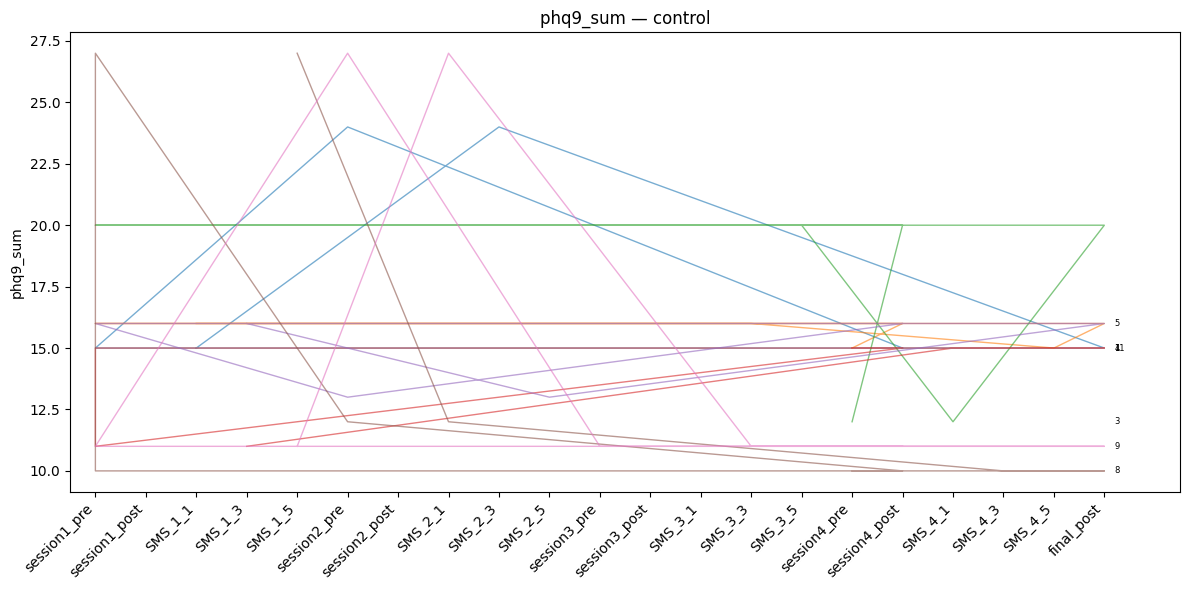

Worsened trajectories:


part_id      timepoint  phq9_sum
0       4        SMS_1_3      11.0
1       4        SMS_4_1      15.0
2       4     final_post      15.0
3       4   session1_pre      15.0
4       4   session1_pre      11.0
5       4  session4_post      15.0
6       4   session4_pre      15.0


── phq9_sum  |  Condition: intervention ──


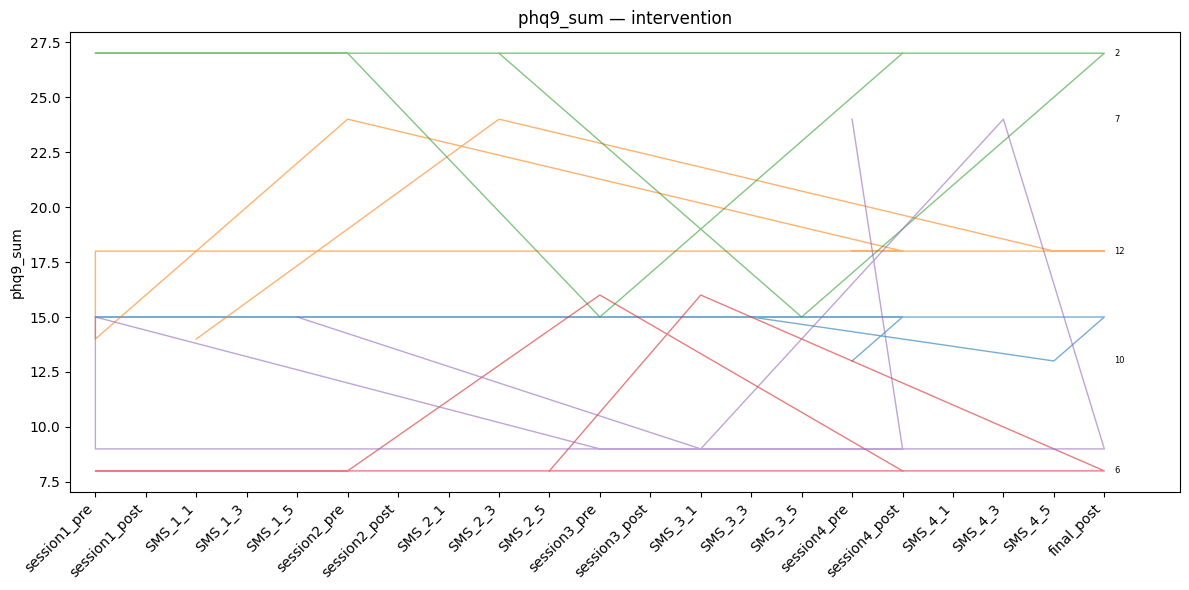

Worsened trajectories:


part_id      timepoint  phq9_sum
0       12        SMS_1_1      14.0
1       12        SMS_2_3      24.0
2       12        SMS_4_5      18.0
3       12     final_post      18.0
4       12   session1_pre      18.0
5       12   session1_pre      14.0
6       12   session2_pre      24.0
7       12  session4_post      18.0
8       12   session4_pre      18.0
9        7        SMS_1_5      15.0
10       7        SMS_3_1       9.0
11       7        SMS_4_3      24.0
12       7     final_post       9.0
13       7   session1_pre       9.0
14       7   session1_pre      15.0
15       7   session3_pre       9.0
16       7  session4_post       9.0
17       7   session4_pre      24.0


── phq9_sum  |  Condition: nan ──


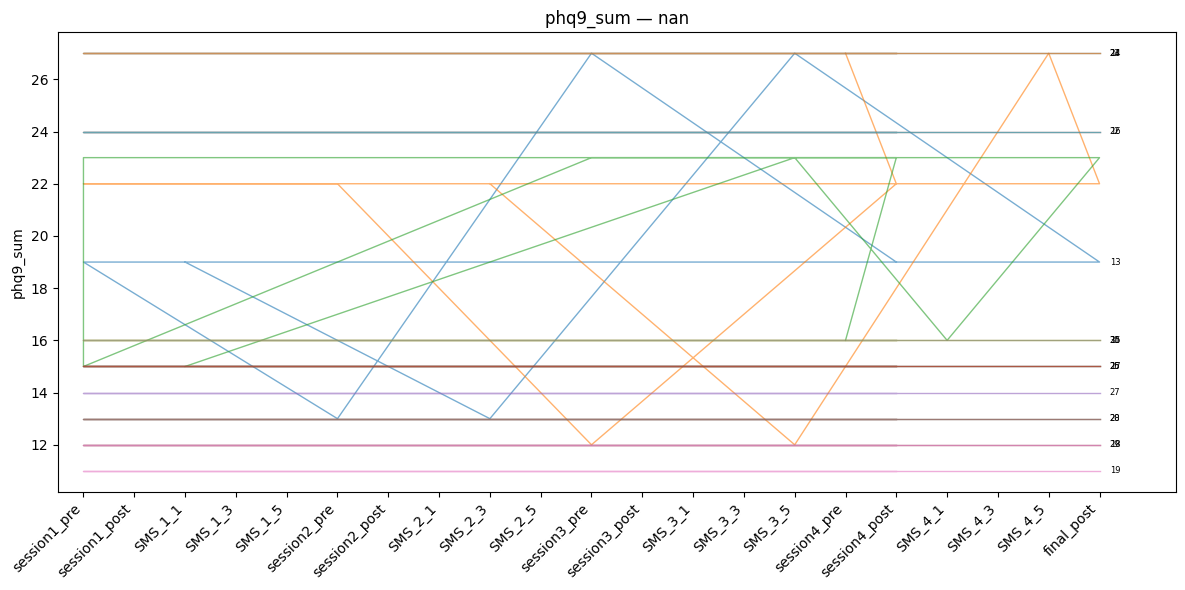

Worsened trajectories:


part_id      timepoint  phq9_sum
0       14        SMS_2_3      22.0
1       14        SMS_3_5      12.0
2       14        SMS_4_5      27.0
3       14     final_post      22.0
4       14   session1_pre      22.0
5       14   session2_pre      22.0
6       14   session3_pre      12.0
7       14  session4_post      22.0
8       14   session4_pre      27.0
9       15        SMS_1_1      15.0
10      15        SMS_3_5      23.0
11      15        SMS_4_1      16.0
12      15     final_post      23.0
13      15   session1_pre      23.0
14      15   session1_pre      15.0
15      15   session3_pre      23.0
16      15  session4_post      23.0
17      15   session4_pre      16.0


── spane_p  |  Condition: control ──


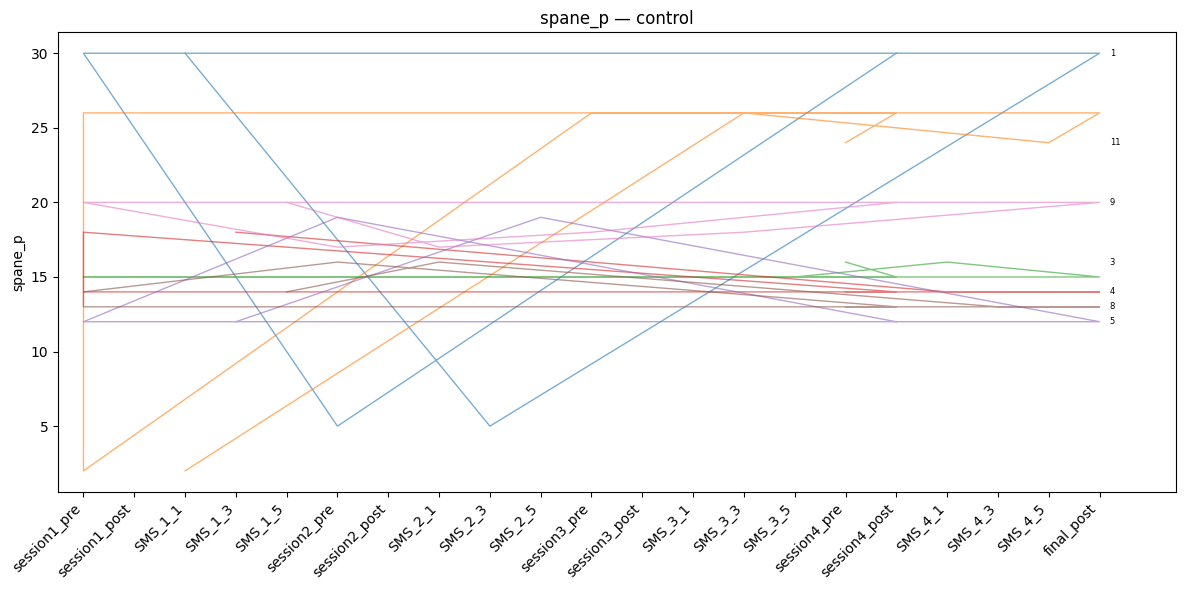

Worsened trajectories:


part_id      timepoint  spane_p
0        4        SMS_1_3     18.0
1        4        SMS_4_1     14.0
2        4     final_post     14.0
3        4   session1_pre     14.0
4        4   session1_pre     18.0
5        4  session4_post     14.0
6        4   session4_pre     14.0
7        8        SMS_1_5     14.0
8        8        SMS_2_1     16.0
9        8        SMS_4_3     13.0
10       8     final_post     13.0
11       8   session1_pre     13.0
12       8   session1_pre     14.0
13       8   session2_pre     16.0
14       8  session4_post     13.0
15       8   session4_pre     13.0


── spane_p  |  Condition: intervention ──


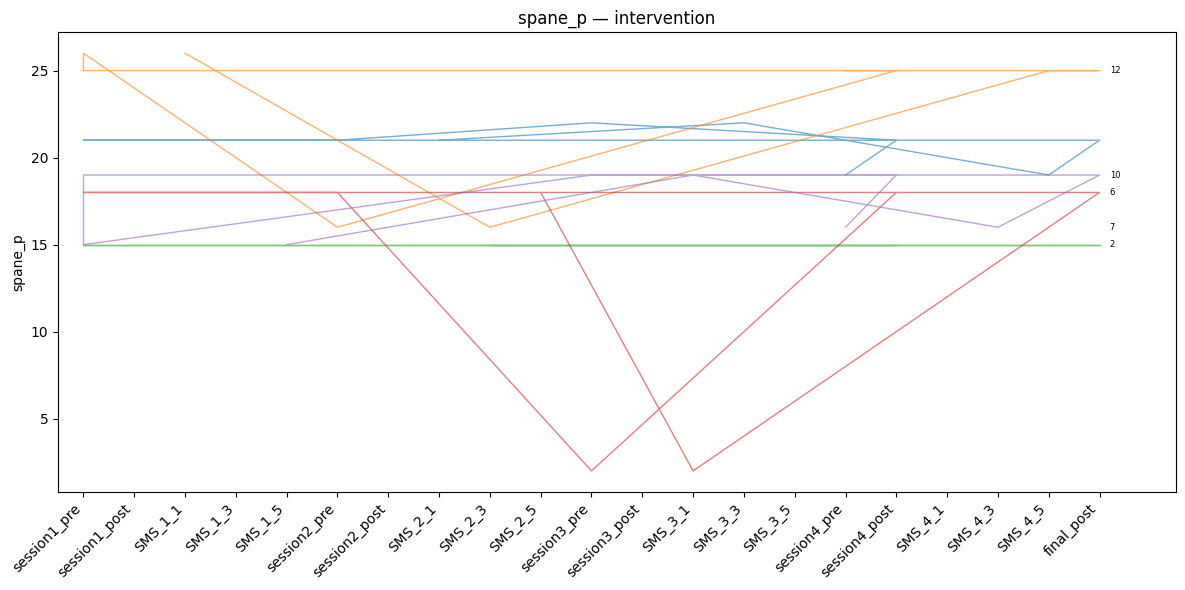

Worsened trajectories:


part_id      timepoint  spane_p
0       10        SMS_2_1     21.0
1       10        SMS_3_3     22.0
2       10        SMS_4_5     19.0
3       10     final_post     21.0
4       10   session1_pre     21.0
5       10   session2_pre     21.0
6       10   session3_pre     22.0
7       10  session4_post     21.0
8       10   session4_pre     19.0
9       12        SMS_1_1     26.0
10      12        SMS_2_3     16.0
11      12        SMS_4_5     25.0
12      12     final_post     25.0
13      12   session1_pre     25.0
14      12   session1_pre     26.0
15      12   session2_pre     16.0
16      12  session4_post     25.0
17      12   session4_pre     25.0


── spane_p  |  Condition: nan ──


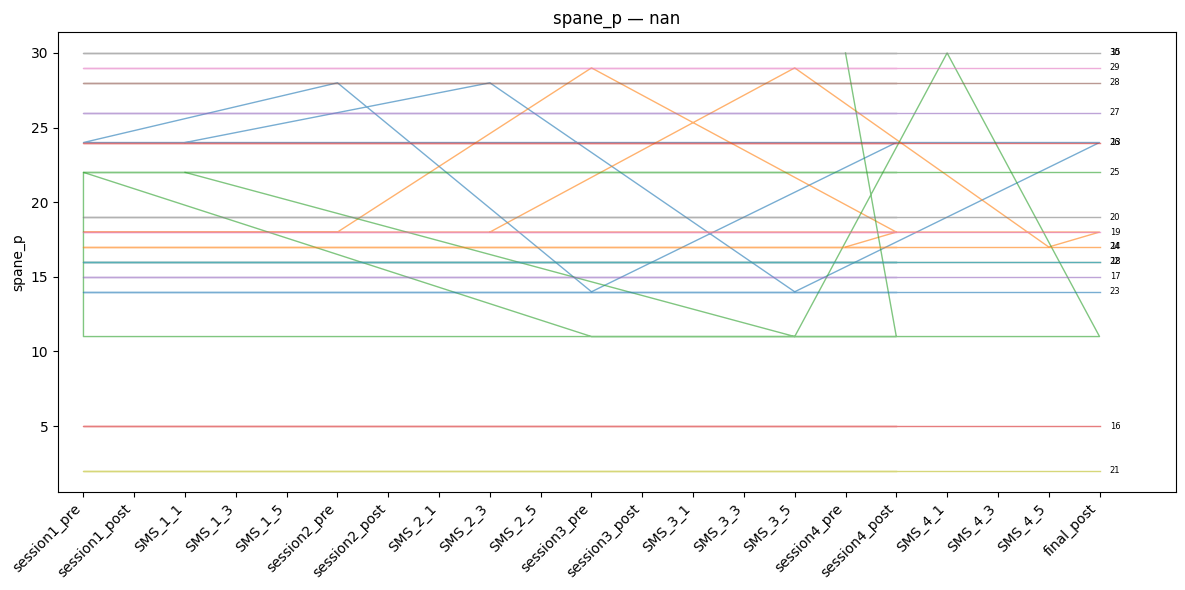

Worsened trajectories:


part_id      timepoint  spane_p
0      14        SMS_2_3     18.0
1      14        SMS_3_5     29.0
2      14        SMS_4_5     17.0
3      14     final_post     18.0
4      14   session1_pre     18.0
5      14   session2_pre     18.0
6      14   session3_pre     29.0
7      14  session4_post     18.0
8      14   session4_pre     17.0


── spane_n  |  Condition: control ──


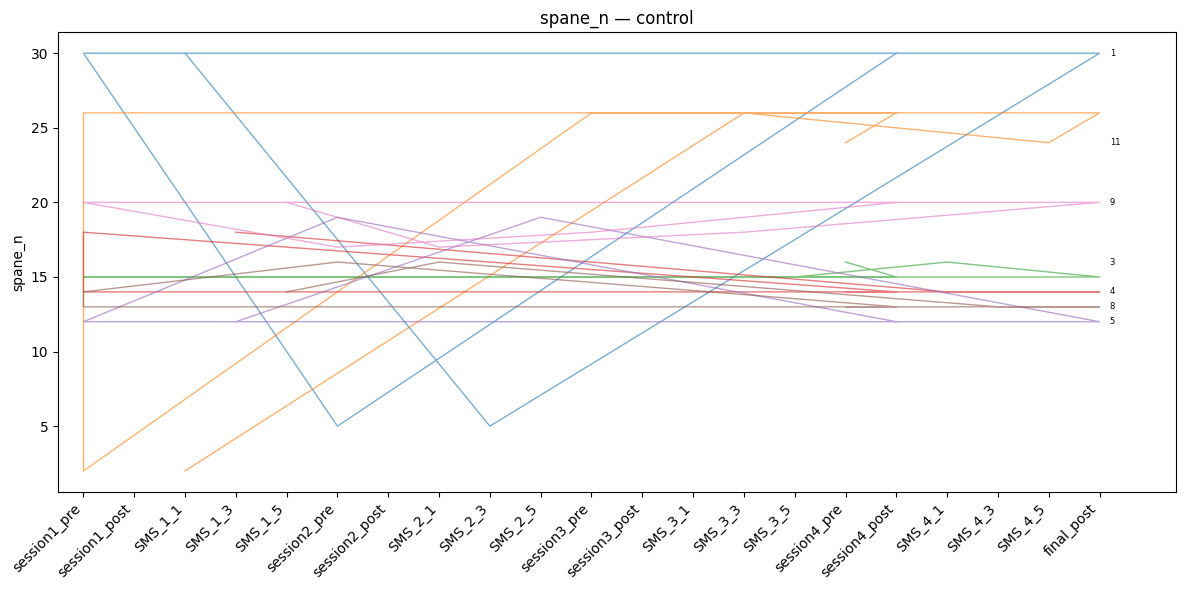

Worsened trajectories:


part_id      timepoint  spane_n
0       11        SMS_1_1      2.0
1       11        SMS_3_3     26.0
2       11        SMS_4_5     24.0
3       11     final_post     26.0
4       11   session1_pre     26.0
5       11   session1_pre      2.0
6       11   session3_pre     26.0
7       11  session4_post     26.0
8       11   session4_pre     24.0
9        3        SMS_3_5     15.0
10       3        SMS_4_1     16.0
11       3     final_post     15.0
12       3   session1_pre     15.0
13       3   session3_pre     15.0
14       3  session4_post     15.0
15       3   session4_pre     16.0


── spane_n  |  Condition: intervention ──


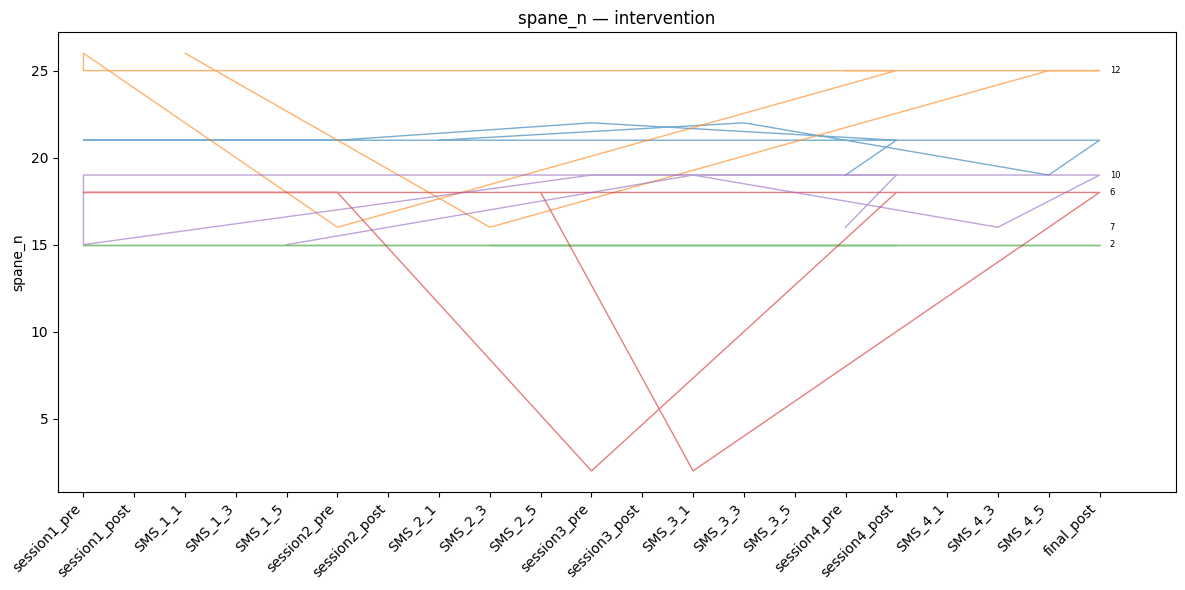

Worsened trajectories:


part_id      timepoint  spane_n
0       7        SMS_1_5     15.0
1       7        SMS_3_1     19.0
2       7        SMS_4_3     16.0
3       7     final_post     19.0
4       7   session1_pre     19.0
5       7   session1_pre     15.0
6       7   session3_pre     19.0
7       7  session4_post     19.0
8       7   session4_pre     16.0


── spane_n  |  Condition: nan ──


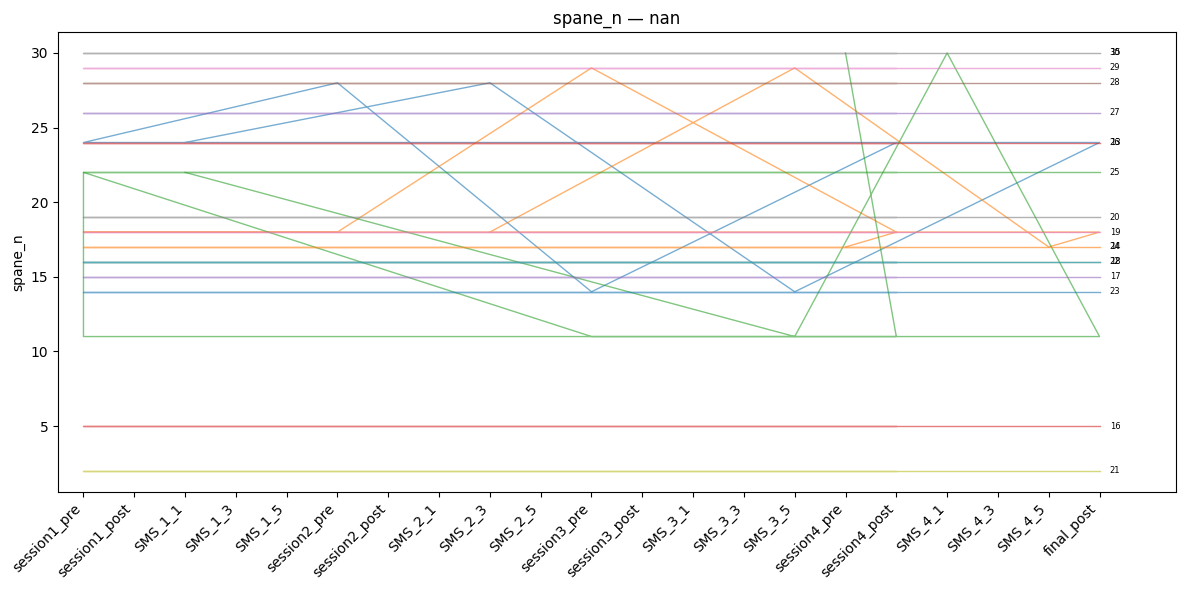

Worsened trajectories:


part_id      timepoint  spane_n
0      15        SMS_1_1     22.0
1      15        SMS_3_5     11.0
2      15        SMS_4_1     30.0
3      15     final_post     11.0
4      15   session1_pre     11.0
5      15   session1_pre     22.0
6      15   session3_pre     11.0
7      15  session4_post     11.0
8      15   session4_pre     30.0


── m3vas_mood  |  Condition: control ──


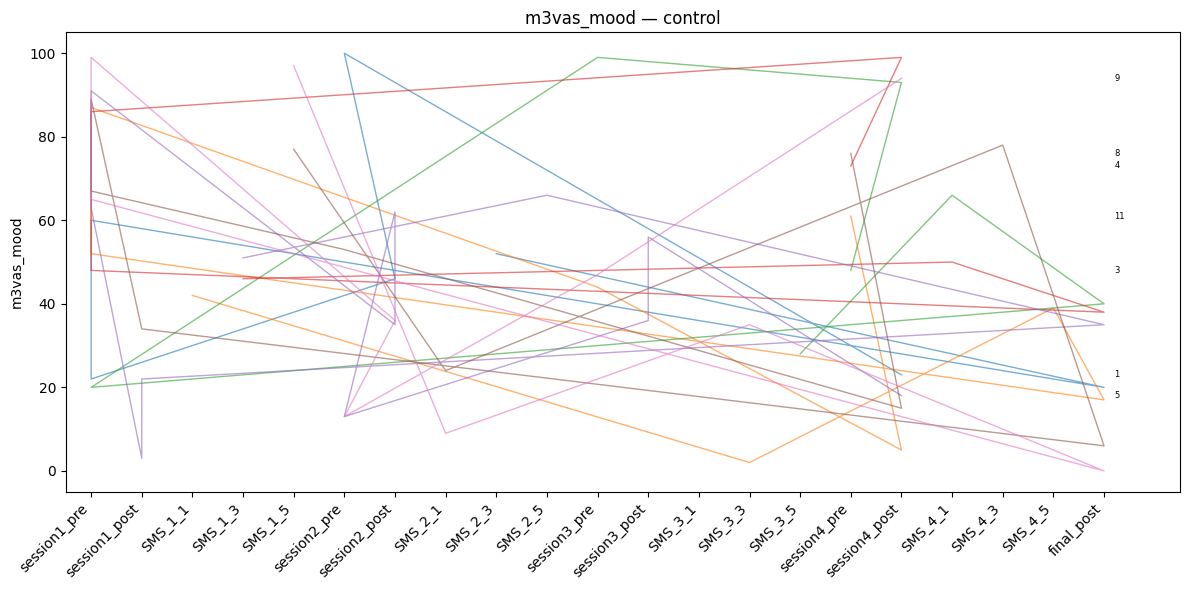

Worsened trajectories:


part_id      timepoint  m3vas_mood
0        1        SMS_2_3        52.0
1        1     final_post        20.0
2        1   session1_pre        60.0
3        1   session1_pre        22.0
4        1  session2_post        46.0
5        1   session2_pre       100.0
6        1  session4_post        23.0
7        5        SMS_1_3        51.0
8        5        SMS_2_5        66.0
9        5     final_post        35.0
10       5  session1_post        22.0
11       5  session1_post         3.0
12       5   session1_pre        63.0
13       5   session1_pre        91.0
14       5  session2_post        35.0
15       5  session2_post        62.0
16       5   session2_pre        13.0
17       5  session3_post        36.0
18       5  session3_post        56.0
19       5  session4_post        18.0
20       8        SMS_1_5        77.0
21       8        SMS_2_1        24.0
22       8        SMS_4_3        78.0
23       8     final_post         6.0
24       8  session1_post        34.0
25       8   session1_pre        89.0
26       8   session1_pre        67.0
27       8   session2_pre        53.0
28       8  session4_post        15.0
29       8   session4_pre        76.0
30       9        SMS_1_5        97.0
31       9        SMS_2_1         9.0
32       9        SMS_3_3        35.0
33       9     final_post         0.0
34       9   session1_pre        65.0
35       9   session1_pre        99.0
36       9  session2_post        36.0
37       9   session2_pre        13.0
38       9   session3_pre        47.0
39       9  session4_post        94.0


── m3vas_mood  |  Condition: intervention ──


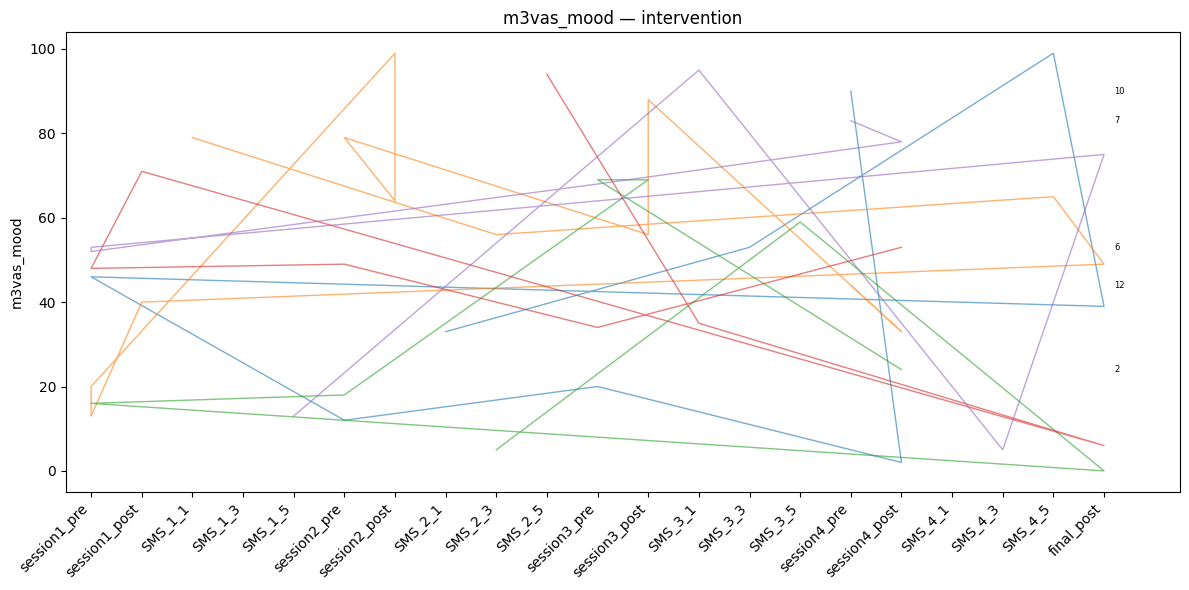

Worsened trajectories:


part_id      timepoint  m3vas_mood
0       12        SMS_1_1        79.0
1       12        SMS_2_3        56.0
2       12        SMS_4_5        65.0
3       12     final_post        49.0
4       12  session1_post        40.0
5       12   session1_pre        13.0
6       12   session1_pre        20.0
7       12  session2_post        99.0
8       12  session2_post        64.0
9       12   session2_pre        79.0
10      12  session3_post        56.0
11      12  session3_post        88.0
12      12  session4_post        33.0
13      12   session4_pre        44.0
14       6        SMS_2_5        94.0
15       6        SMS_3_1        35.0
16       6     final_post         6.0
17       6  session1_post        71.0
18       6   session1_pre        48.0
19       6   session2_pre        49.0
20       6   session3_pre        34.0
21       6  session4_post        53.0


── m3vas_mood  |  Condition: nan ──


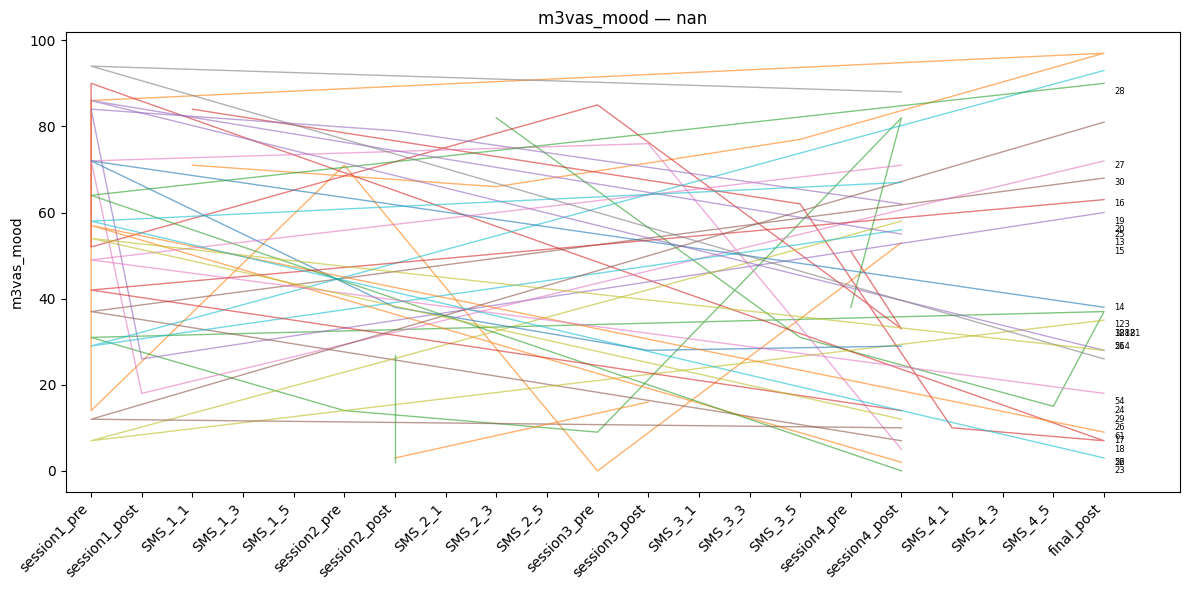

Worsened trajectories:


part_id      timepoint  m3vas_mood
0       13        SMS_1_1        71.0
1       13        SMS_2_3        66.0
2       13        SMS_3_5        77.0
3       13     final_post        97.0
4       13   session1_pre        86.0
5       13   session1_pre        14.0
6       13   session2_pre        71.0
7       13   session3_pre         0.0
8       13  session4_post        53.0
9       14        SMS_2_3        82.0
10      14        SMS_3_5        31.0
11      14        SMS_4_5        15.0
12      14     final_post        37.0
13      14   session1_pre        31.0
14      14   session2_pre        14.0
15      14   session3_pre         9.0
16      14  session4_post        82.0
17      14   session4_pre        38.0
18      15        SMS_1_1        84.0
19      15        SMS_3_5        62.0
20      15        SMS_4_1        10.0
21      15     final_post         7.0
22      15   session1_pre        90.0
23      15   session1_pre        52.0
24      15   session3_pre        85.0
25      15  session4_post        33.0
26      15   session4_pre        51.0
27      17     final_post        68.0
28      17   session1_pre        37.0
29      17  session4_post         7.0
30      18     final_post        72.0
31      18  session1_post        18.0
32      18   session1_pre        72.0
33      18  session3_post        76.0
34      18  session4_post         5.0
35      20     final_post        93.0
36      20   session1_pre        29.0
37      20  session4_post        56.0
38      21     final_post        38.0
39      21   session1_pre        72.0
40      21  session2_post        38.0
41      21  session3_post        28.0
42      21  session4_post        29.0
43      22     final_post         9.0
44      22   session1_pre        57.0
45      22  session4_post         2.0
46      23     final_post        90.0
47      23   session1_pre        64.0
48      23  session4_post         0.0
49      24     final_post        63.0
50      24   session1_pre        42.0
51      24  session4_post        14.0
52      26     final_post        81.0
53      26   session1_pre        12.0
54      26  session4_post        10.0
55      29     final_post        28.0
56      29   session1_pre        54.0
57      29  session4_post        12.0
58      56  session2_post        27.0
59      56  session2_post         2.0


── m3vas_pleasure  |  Condition: control ──


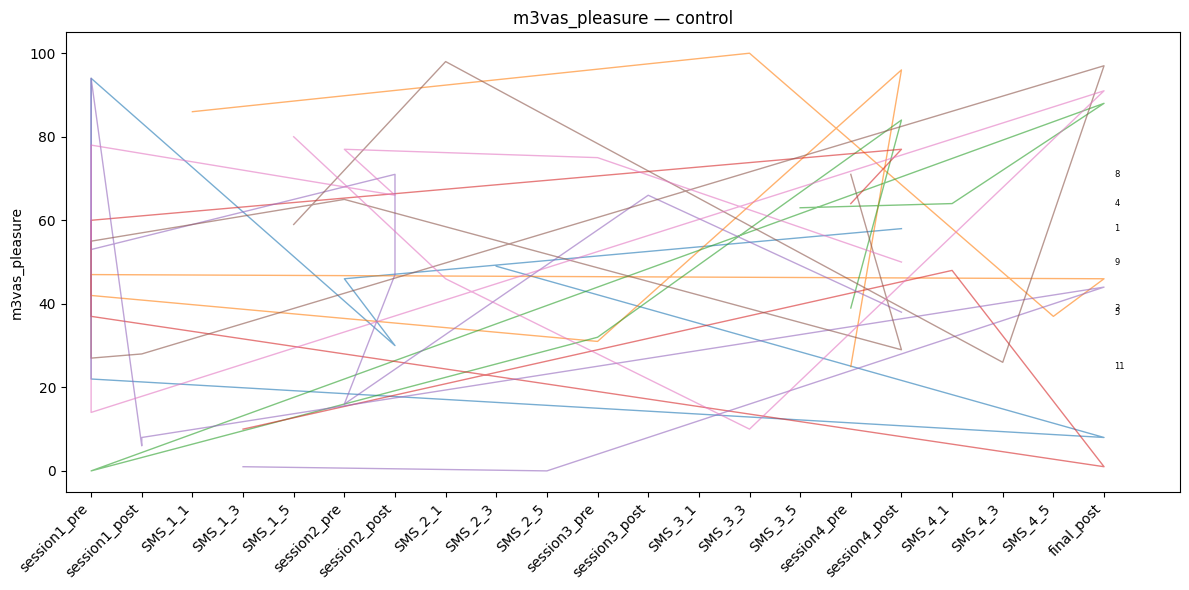

Worsened trajectories:


part_id      timepoint  m3vas_pleasure
0       11        SMS_1_1            86.0
1       11        SMS_3_3           100.0
2       11        SMS_4_5            37.0
3       11     final_post            46.0
4       11   session1_pre            47.0
5       11   session1_pre            42.0
6       11   session3_pre            31.0
7       11  session4_post            96.0
8       11   session4_pre            25.0
9        3        SMS_3_5            63.0
10       3        SMS_4_1            64.0
11       3     final_post            88.0
12       3   session1_pre             0.0
13       3   session3_pre            32.0
14       3  session4_post            84.0
15       3   session4_pre            39.0
16       9        SMS_1_5            80.0
17       9        SMS_2_1            46.0
18       9        SMS_3_3            10.0
19       9     final_post            91.0
20       9   session1_pre            14.0
21       9   session1_pre            78.0
22       9  session2_post            66.0
23       9   session2_pre            77.0
24       9   session3_pre            75.0
25       9  session4_post            50.0


── m3vas_pleasure  |  Condition: intervention ──


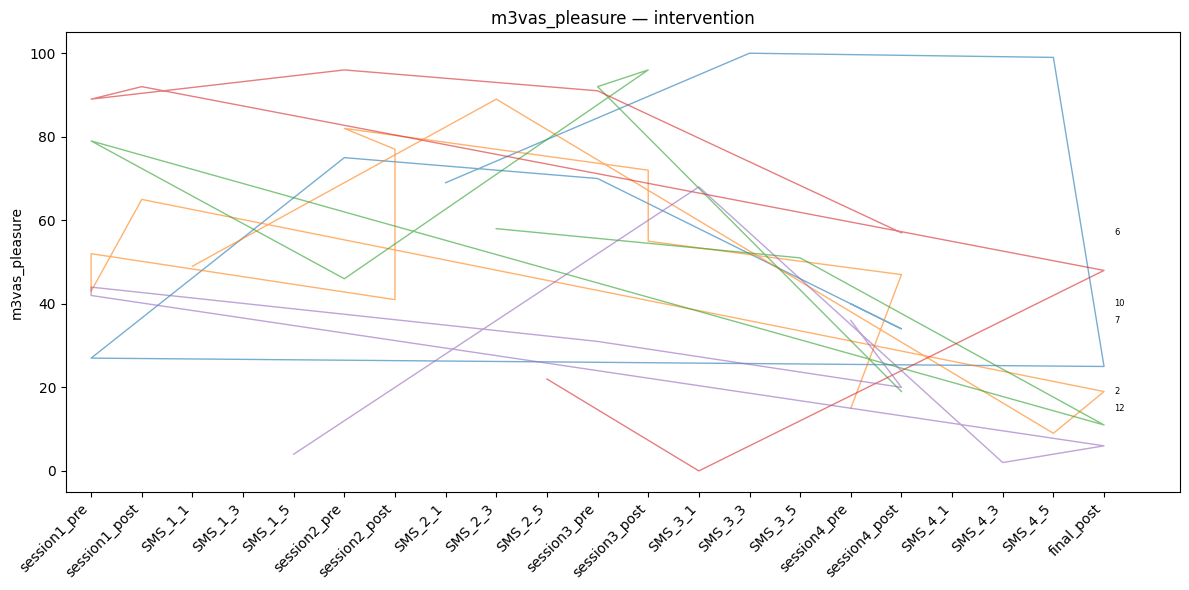

Worsened trajectories:


part_id      timepoint  m3vas_pleasure
0       10        SMS_2_1            69.0
1       10        SMS_3_3           100.0
2       10        SMS_4_5            99.0
3       10     final_post            25.0
4       10   session1_pre            27.0
5       10   session2_pre            75.0
6       10   session3_pre            70.0
7       10  session4_post            34.0
8       10   session4_pre            40.0
9       12        SMS_1_1            49.0
10      12        SMS_2_3            89.0
11      12        SMS_4_5             9.0
12      12     final_post            19.0
13      12  session1_post            65.0
14      12   session1_pre            43.0
15      12   session1_pre            52.0
16      12  session2_post            41.0
17      12  session2_post            77.0
18      12   session2_pre            82.0
19      12  session3_post            72.0
20      12  session3_post            55.0
21      12  session4_post            47.0
22      12   session4_pre            15.0
23       2        SMS_2_3            58.0
24       2        SMS_3_5            51.0
25       2     final_post            11.0
26       2   session1_pre            79.0
27       2   session2_pre            46.0
28       2  session3_post            96.0
29       2   session3_pre            92.0
30       2  session4_post            19.0


── m3vas_pleasure  |  Condition: nan ──


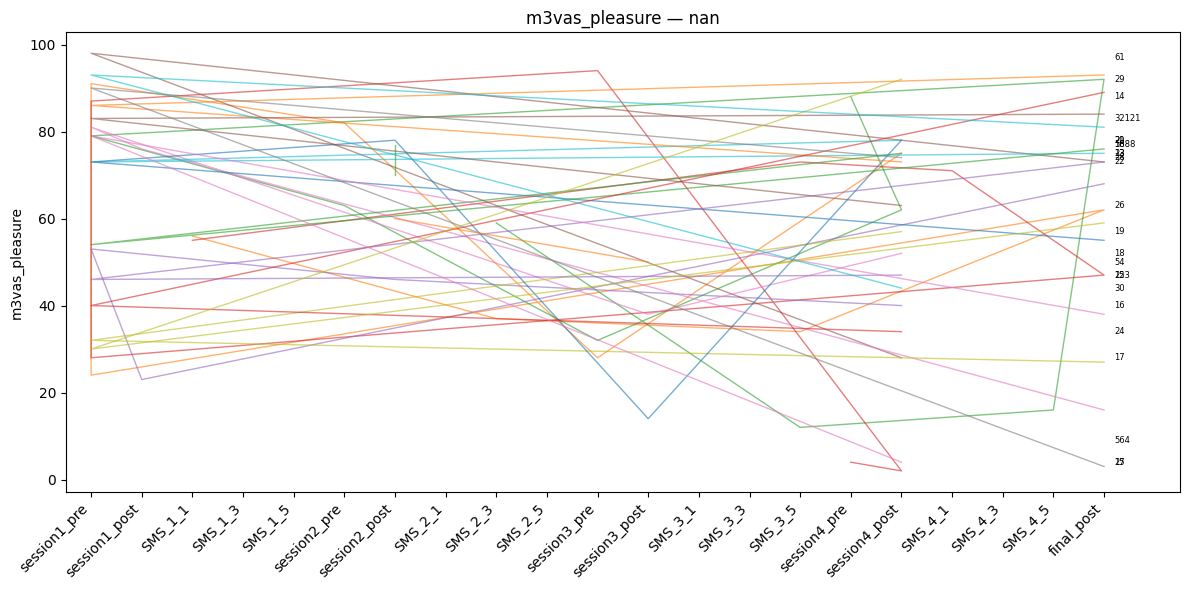

Worsened trajectories:


part_id      timepoint  m3vas_pleasure
0       15        SMS_1_1            55.0
1       15        SMS_3_5            73.0
2       15        SMS_4_1            71.0
3       15     final_post            47.0
4       15   session1_pre            28.0
5       15   session1_pre            87.0
6       15   session3_pre            94.0
7       15  session4_post             2.0
8       15   session4_pre             4.0
9       16     final_post            68.0
10      16  session1_post            23.0
11      16   session1_pre            53.0
12      16  session2_post            46.0
13      16  session4_post            40.0
14      17     final_post            73.0
15      17   session1_pre            98.0
16      17  session4_post            28.0
17      22     final_post            93.0
18      22   session1_pre            86.0
19      22  session4_post            73.0
20      23     final_post            76.0
21      23   session1_pre            54.0
22      23  session4_post            75.0
23      24     final_post            89.0
24      24   session1_pre            40.0
25      24  session4_post            34.0
26      25     final_post            73.0
27      25   session1_pre            46.0
28      25  session4_post            47.0
29      26     final_post            84.0
30      26   session1_pre            83.0
31      26  session4_post            63.0
32      27     final_post            38.0
33      27   session1_pre            79.0
34      27  session4_post             4.0
35      30     final_post            81.0
36      30   session1_pre            93.0
37      30  session4_post            44.0
38      54  session2_post            60.0
39      54  session3_post            50.0


── m3vas_suicidal  |  Condition: control ──


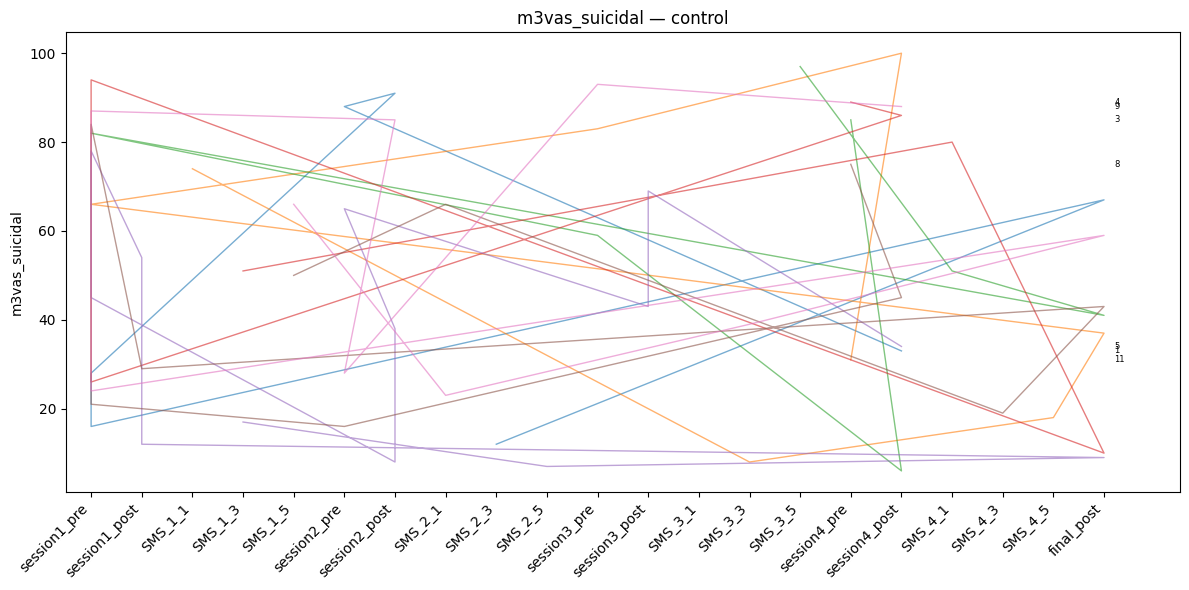

Worsened trajectories:


part_id      timepoint  m3vas_suicidal
0        1        SMS_2_3            12.0
1        1     final_post            67.0
2        1   session1_pre            16.0
3        1   session1_pre            28.0
4        1  session2_post            91.0
5        1   session2_pre            88.0
6        1  session4_post            33.0
7        4        SMS_1_3            51.0
8        4        SMS_4_1            80.0
9        4     final_post            10.0
10       4   session1_pre            94.0
11       4   session1_pre            26.0
12       4  session4_post            86.0
13       4   session4_pre            89.0
14       5        SMS_1_3            17.0
15       5        SMS_2_5             7.0
16       5     final_post             9.0
17       5  session1_post            12.0
18       5  session1_post            54.0
19       5   session1_pre            78.0
20       5   session1_pre            45.0
21       5  session2_post             8.0
22       5  session2_post            38.0
23       5   session2_pre            65.0
24       5  session3_post            43.0
25       5  session3_post            69.0
26       5  session4_post            34.0
27       8        SMS_1_5            50.0
28       8        SMS_2_1            66.0
29       8        SMS_4_3            19.0
30       8     final_post            43.0
31       8  session1_post            29.0
32       8   session1_pre            84.0
33       8   session1_pre            21.0
34       8   session2_pre            16.0
35       8  session4_post            45.0
36       8   session4_pre            75.0
37       9        SMS_1_5            66.0
38       9        SMS_2_1            23.0
39       9        SMS_3_3            39.0
40       9     final_post            59.0
41       9   session1_pre            24.0
42       9   session1_pre            87.0
43       9  session2_post            85.0
44       9   session2_pre            28.0
45       9   session3_pre            93.0
46       9  session4_post            88.0


── m3vas_suicidal  |  Condition: intervention ──


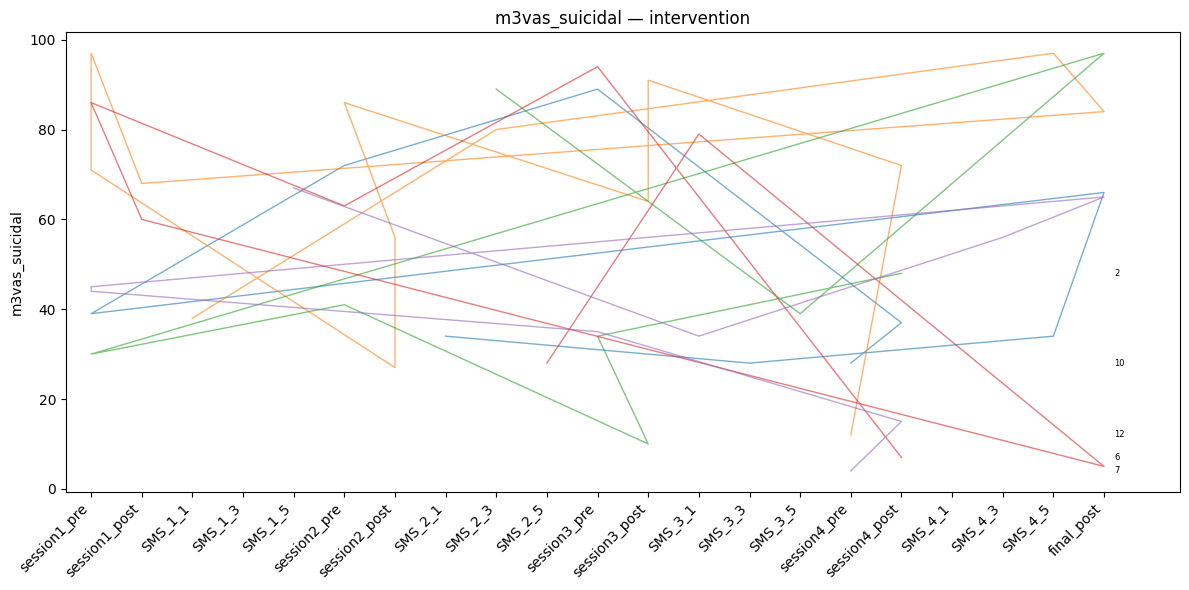

No worsening in this condition.

── m3vas_suicidal  |  Condition: nan ──


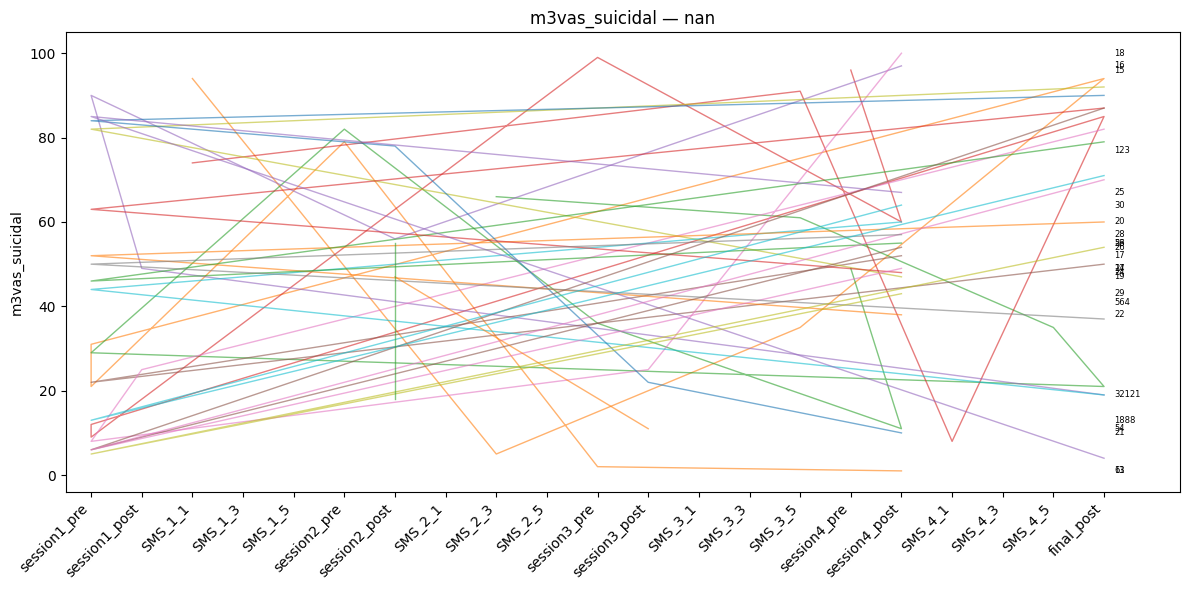

Worsened trajectories:


part_id      timepoint  m3vas_suicidal
0       15        SMS_1_1            74.0
1       15        SMS_3_5            91.0
2       15        SMS_4_1             8.0
3       15     final_post            85.0
4       15   session1_pre            12.0
5       15   session1_pre             9.0
6       15   session3_pre            99.0
7       15  session4_post            60.0
8       15   session4_pre            96.0
9       16     final_post            19.0
10      16  session1_post            49.0
11      16   session1_pre            90.0
12      16  session2_post            56.0
13      16  session4_post            97.0
14      17     final_post            50.0
15      17   session1_pre            22.0
16      17  session4_post            52.0
17      18     final_post            82.0
18      18  session1_post            25.0
19      18   session1_pre             8.0
20      18  session3_post            25.0
21      18  session4_post           100.0
22      20     final_post            19.0
23      20   session1_pre            44.0
24      20  session4_post            60.0
25      25     final_post             4.0
26      25   session1_pre            85.0
27      25  session4_post            67.0
28      28     final_post            37.0
29      28   session1_pre            50.0
30      28  session4_post            57.0
31      56  session2_post            18.0
32      56  session2_post            55.0


── fisber_1  |  Condition: control ──


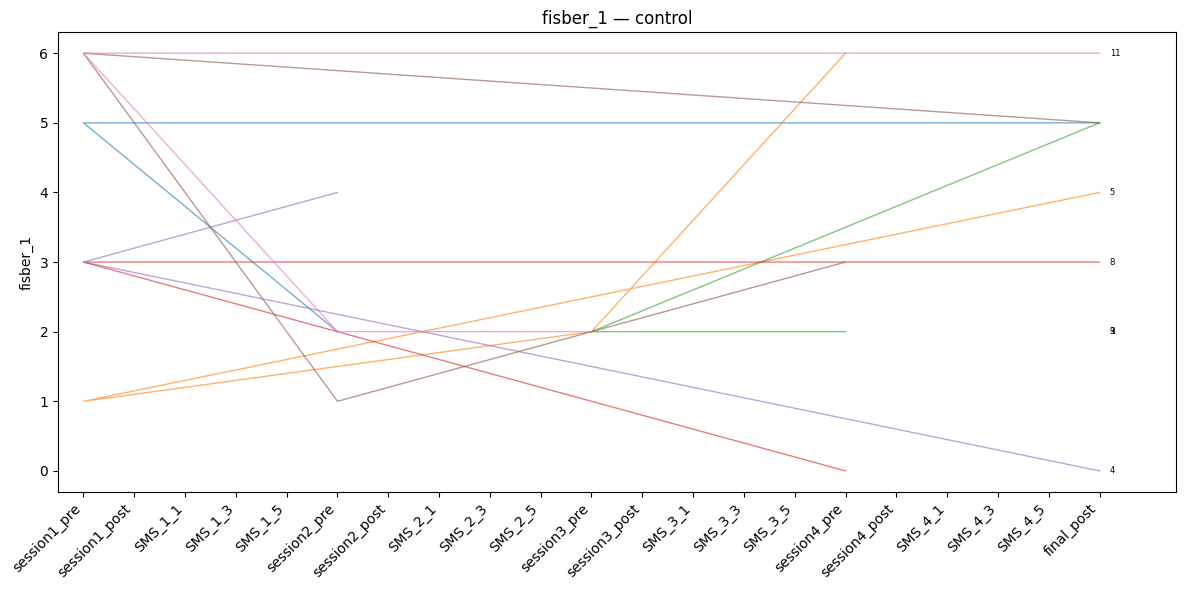

Worsened trajectories:


part_id     timepoint  fisber_1
0      11    final_post       4.0
1      11  session1_pre       1.0
2      11  session3_pre       2.0
3      11  session4_pre       6.0
4       5    final_post       0.0
5       5  session1_pre       3.0
6       5  session2_pre       4.0


── fisber_1  |  Condition: intervention ──


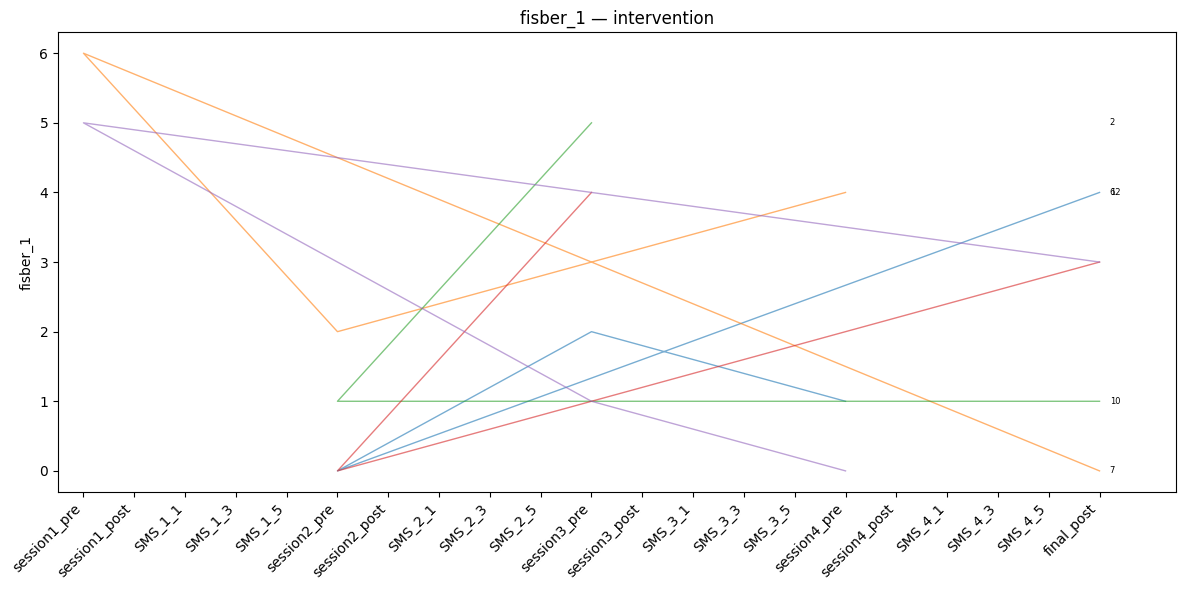

Worsened trajectories:


part_id     timepoint  fisber_1
0      12    final_post       0.0
1      12  session1_pre       6.0
2      12  session2_pre       2.0
3      12  session4_pre       4.0
4       2    final_post       1.0
5       2  session2_pre       1.0
6       2  session3_pre       5.0
7       6    final_post       3.0
8       6  session2_pre       0.0
9       6  session3_pre       4.0


── fisber_1  |  Condition: nan ──


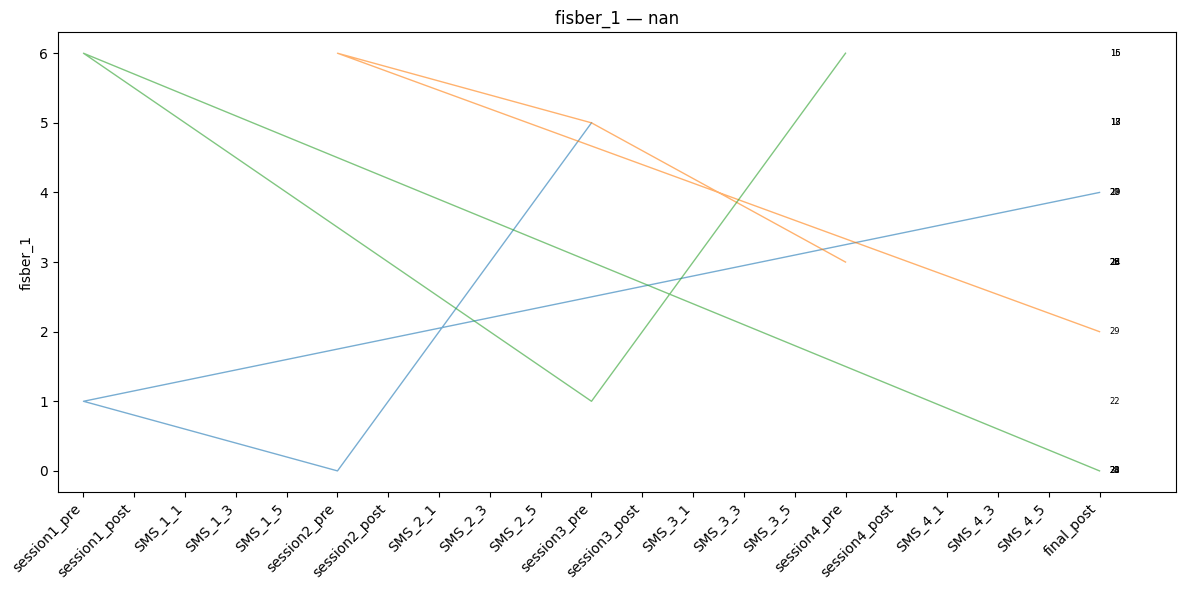

Worsened trajectories:


part_id     timepoint  fisber_1
0       13    final_post       4.0
1       13  session1_pre       1.0
2       13  session2_pre       0.0
3       13  session3_pre       5.0
4       14    final_post       2.0
5       14  session2_pre       6.0
6       14  session3_pre       5.0
7       14  session4_pre       3.0
8       15    final_post       0.0
9       15  session1_pre       6.0
10      15  session3_pre       1.0
11      15  session4_pre       6.0


── fisber_2  |  Condition: control ──


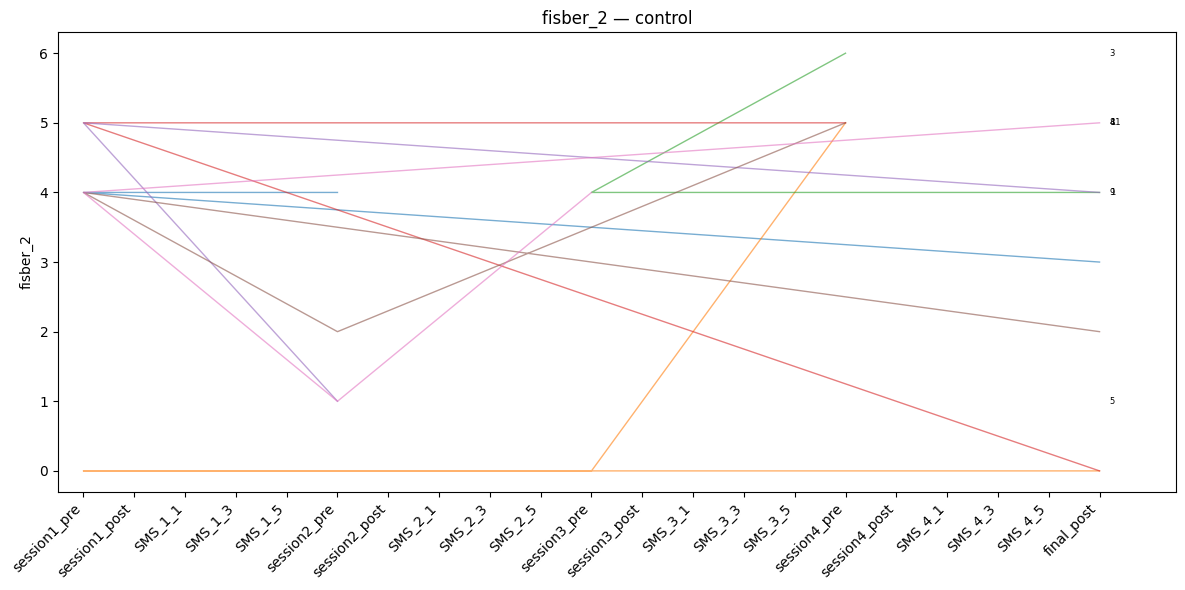

Worsened trajectories:


part_id     timepoint  fisber_2
0        1    final_post       3.0
1        1  session1_pre       4.0
2        1  session2_pre       4.0
3       11    final_post       0.0
4       11  session1_pre       0.0
5       11  session3_pre       0.0
6       11  session4_pre       5.0
7        3    final_post       4.0
8        3  session3_pre       4.0
9        3  session4_pre       6.0
10       4    final_post       0.0
11       4  session1_pre       5.0
12       4  session4_pre       5.0
13       8    final_post       2.0
14       8  session1_pre       4.0
15       8  session2_pre       2.0
16       8  session4_pre       5.0


── fisber_2  |  Condition: intervention ──


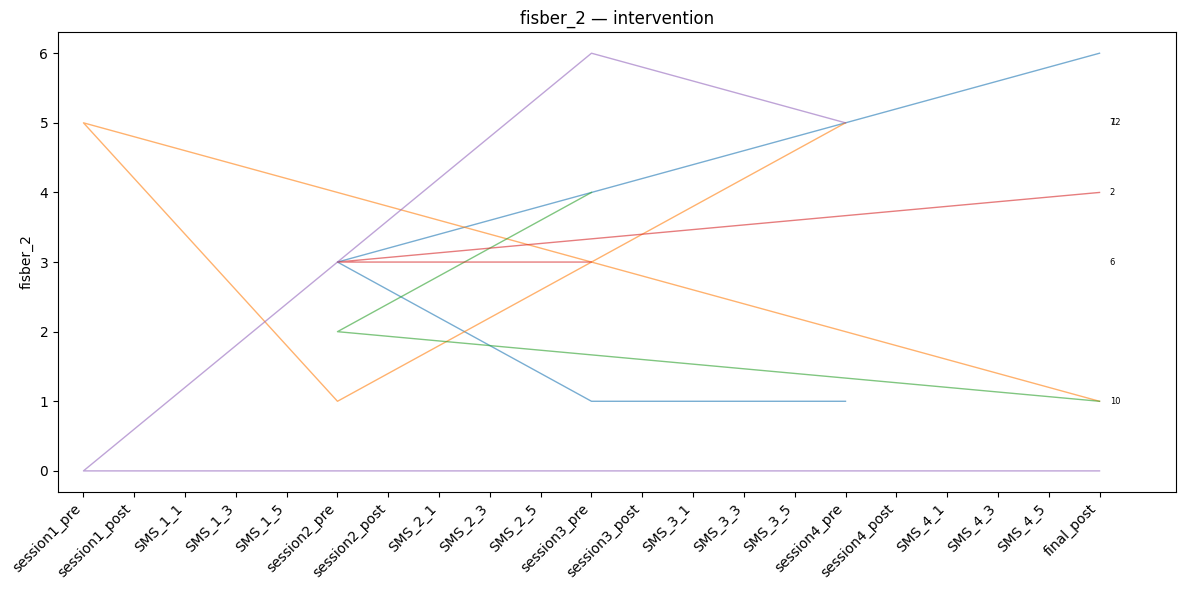

Worsened trajectories:


part_id     timepoint  fisber_2
0       12    final_post       1.0
1       12  session1_pre       5.0
2       12  session2_pre       1.0
3       12  session4_pre       5.0
4        2    final_post       1.0
5        2  session2_pre       2.0
6        2  session3_pre       4.0
7        7    final_post       0.0
8        7  session1_pre       0.0
9        7  session3_pre       6.0
10       7  session4_pre       5.0


── fisber_2  |  Condition: nan ──


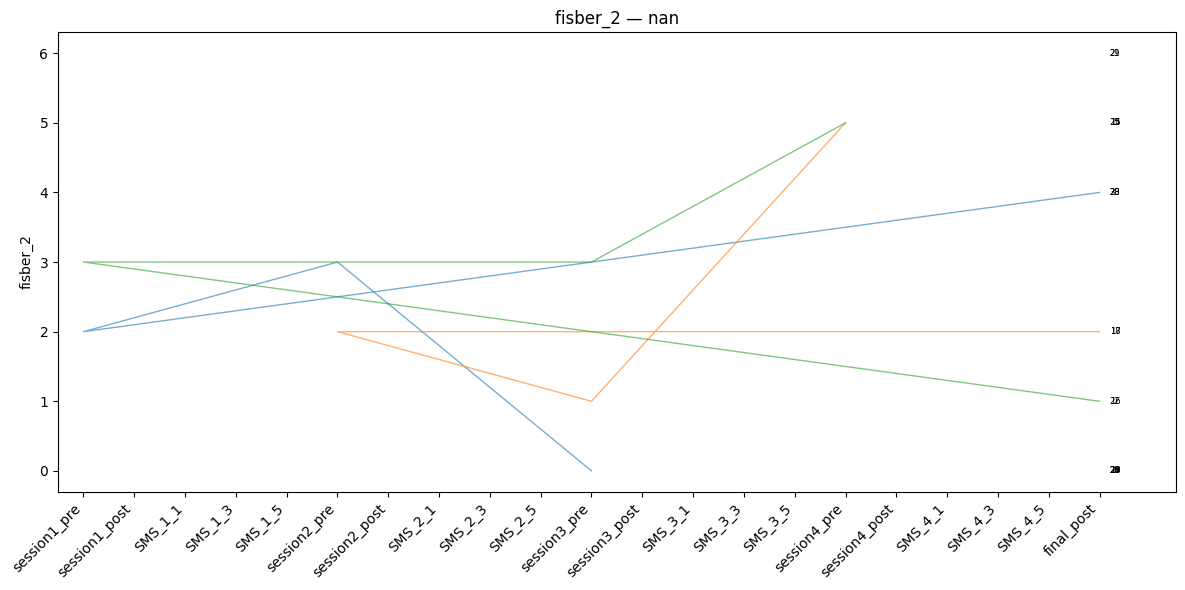

Worsened trajectories:


part_id     timepoint  fisber_2
0      14    final_post       2.0
1      14  session2_pre       2.0
2      14  session3_pre       1.0
3      14  session4_pre       5.0
4      15    final_post       1.0
5      15  session1_pre       3.0
6      15  session3_pre       3.0
7      15  session4_pre       5.0


── fisber_3  |  Condition: control ──


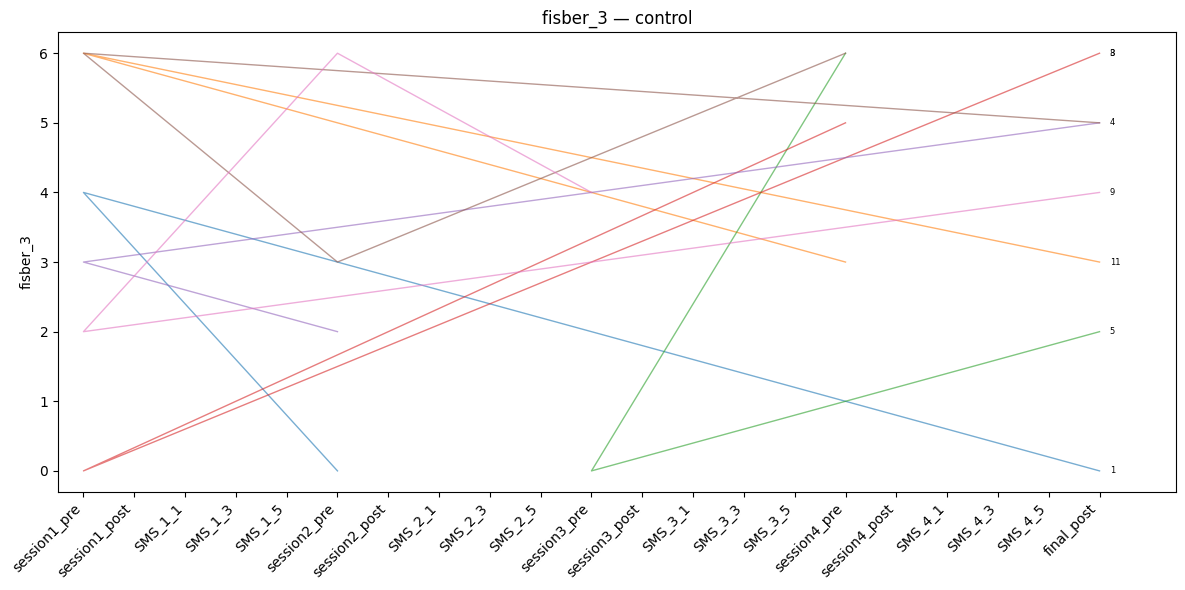

Worsened trajectories:


part_id     timepoint  fisber_3
0       3    final_post       2.0
1       3  session3_pre       0.0
2       3  session4_pre       6.0
3       8    final_post       5.0
4       8  session1_pre       6.0
5       8  session2_pre       3.0
6       8  session4_pre       6.0


── fisber_3  |  Condition: intervention ──


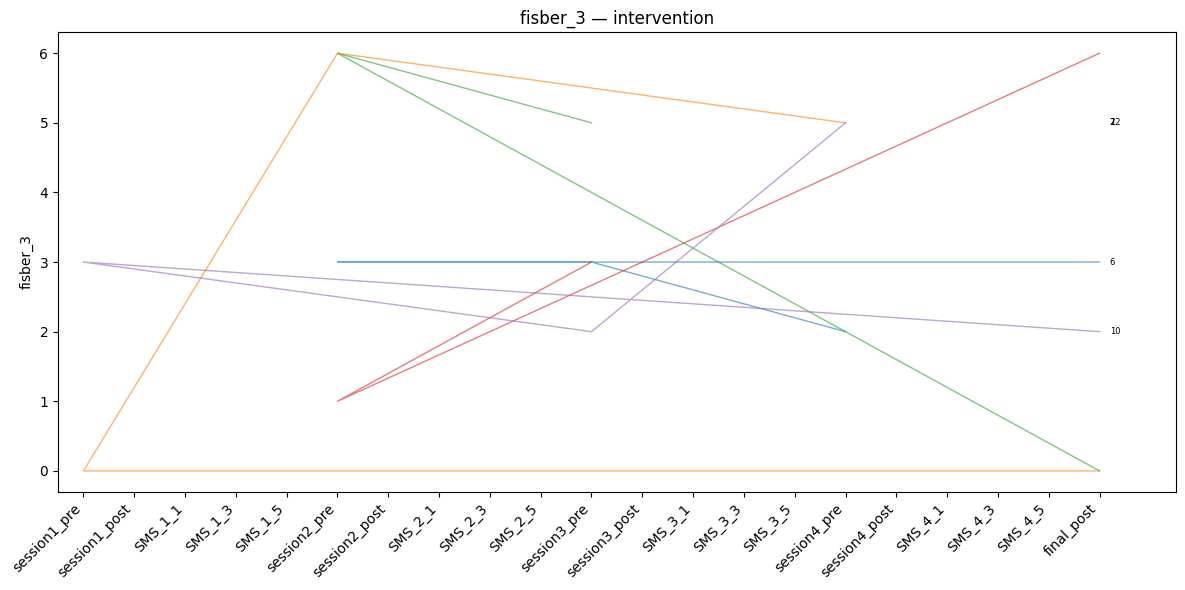

Worsened trajectories:


part_id     timepoint  fisber_3
0       12    final_post       0.0
1       12  session1_pre       0.0
2       12  session2_pre       6.0
3       12  session4_pre       5.0
4        2    final_post       0.0
5        2  session2_pre       6.0
6        2  session3_pre       5.0
7        7    final_post       2.0
8        7  session1_pre       3.0
9        7  session3_pre       2.0
10       7  session4_pre       5.0


── fisber_3  |  Condition: nan ──


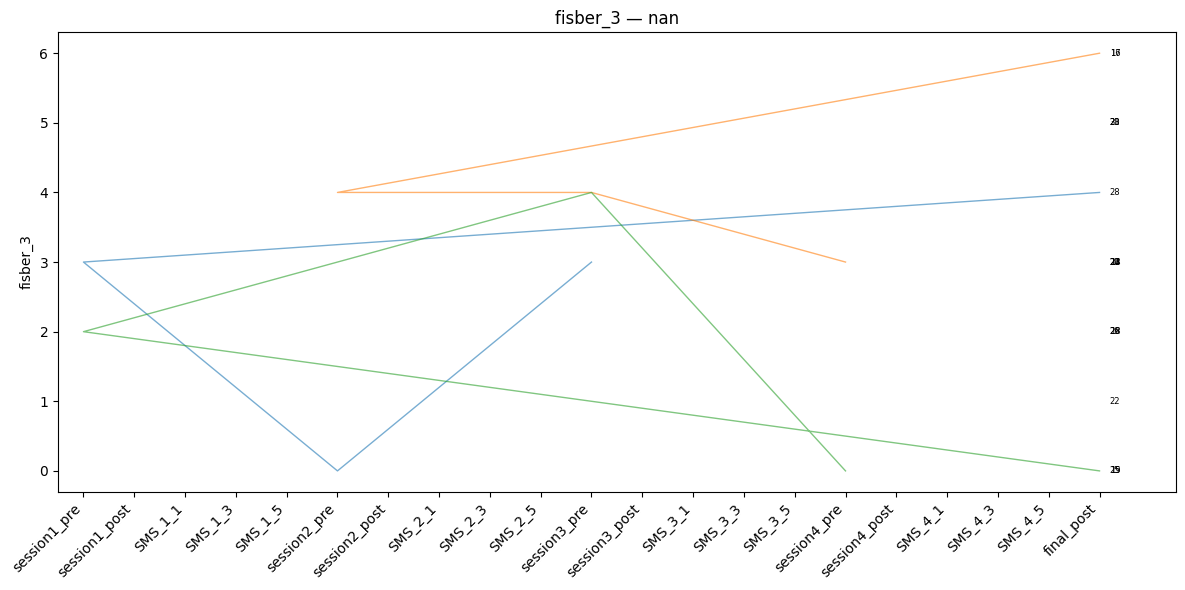

No worsening in this condition.

── bai_sum  |  Condition: control ──


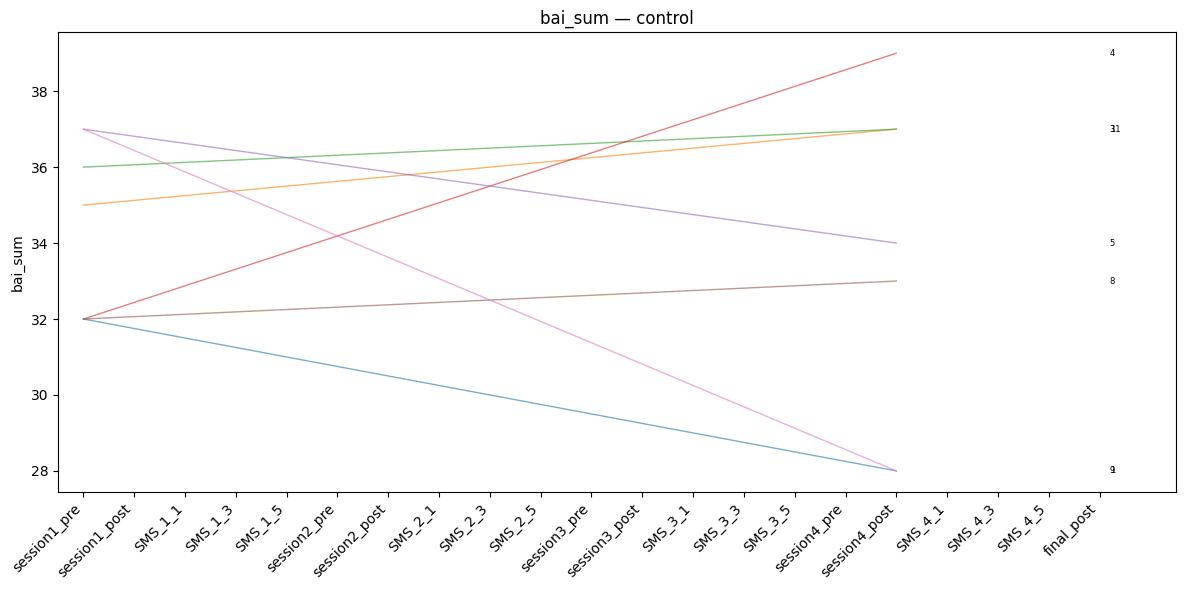

Worsened trajectories:


part_id      timepoint  bai_sum
0      11   session1_pre     35.0
1      11  session4_post     37.0
2       3   session1_pre     36.0
3       3  session4_post     37.0
4       4   session1_pre     32.0
5       4  session4_post     39.0
6       8   session1_pre     32.0
7       8  session4_post     33.0


── bai_sum  |  Condition: intervention ──


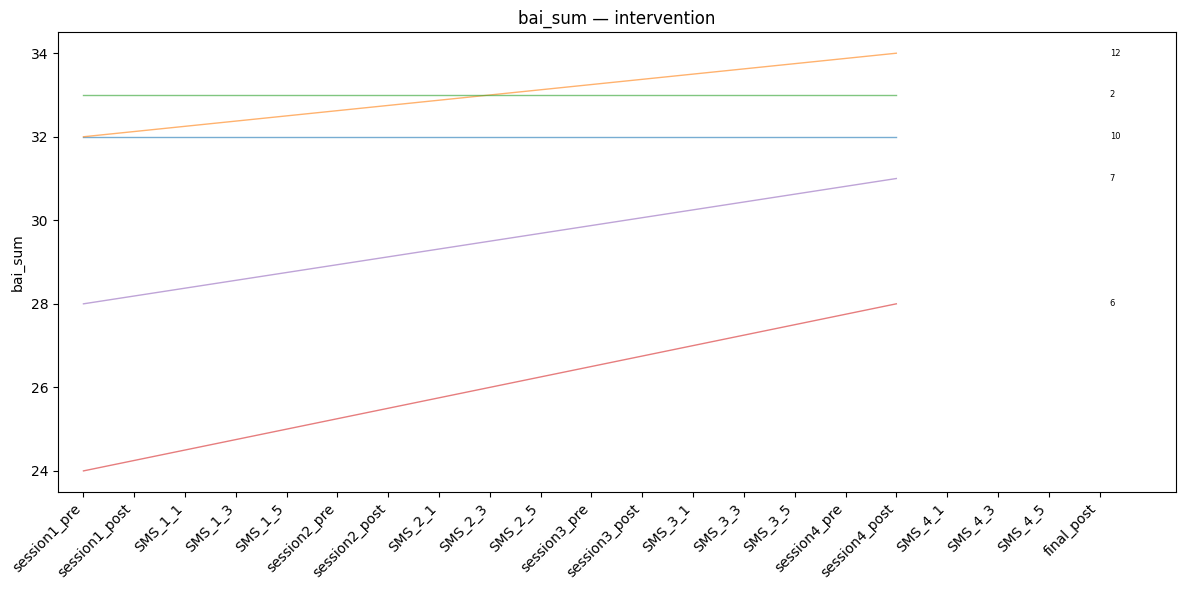

Worsened trajectories:


part_id      timepoint  bai_sum
0      12   session1_pre     32.0
1      12  session4_post     34.0
2       6   session1_pre     24.0
3       6  session4_post     28.0
4       7   session1_pre     28.0
5       7  session4_post     31.0


── bai_sum  |  Condition: nan ──


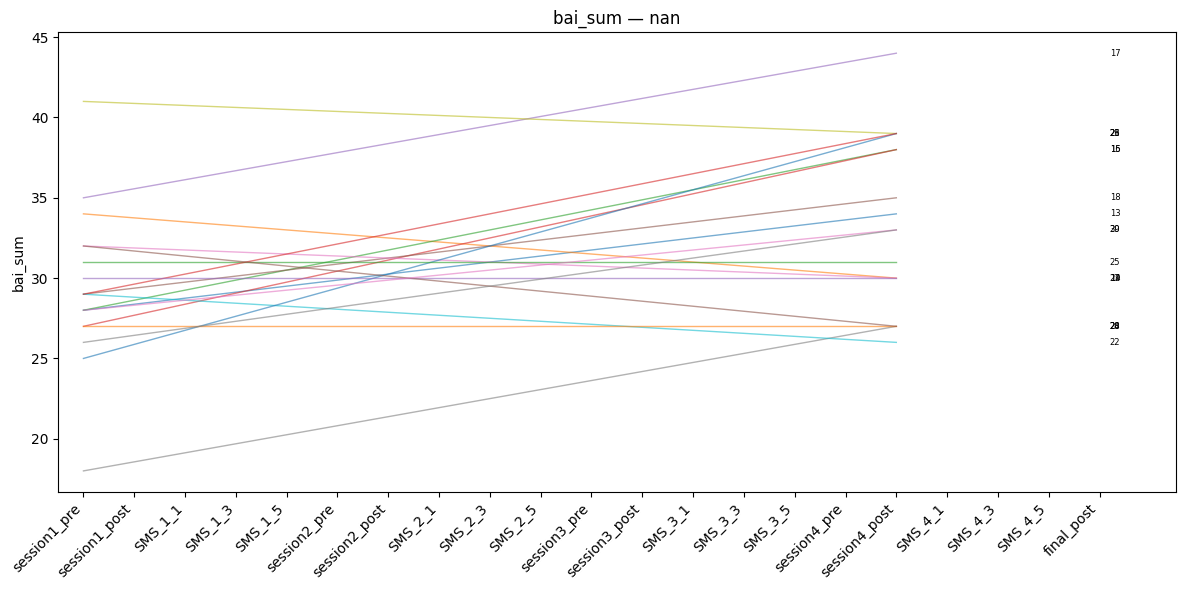

Worsened trajectories:


part_id      timepoint  bai_sum
0       13   session1_pre     28.0
1       13  session4_post     34.0
2       15   session1_pre     28.0
3       15  session4_post     38.0
4       16   session1_pre     27.0
5       16  session4_post     38.0
6       17   session1_pre     35.0
7       17  session4_post     44.0
8       18   session1_pre     29.0
9       18  session4_post     35.0
10      20   session1_pre     18.0
11      20  session4_post     27.0
12      23   session1_pre     25.0
13      23  session4_post     39.0
14      26   session1_pre     29.0
15      26  session4_post     39.0
16      29   session1_pre     28.0
17      29  session4_post     33.0
18      30   session1_pre     26.0
19      30  session4_post     33.0


── bdi_sum  |  Condition: control ──


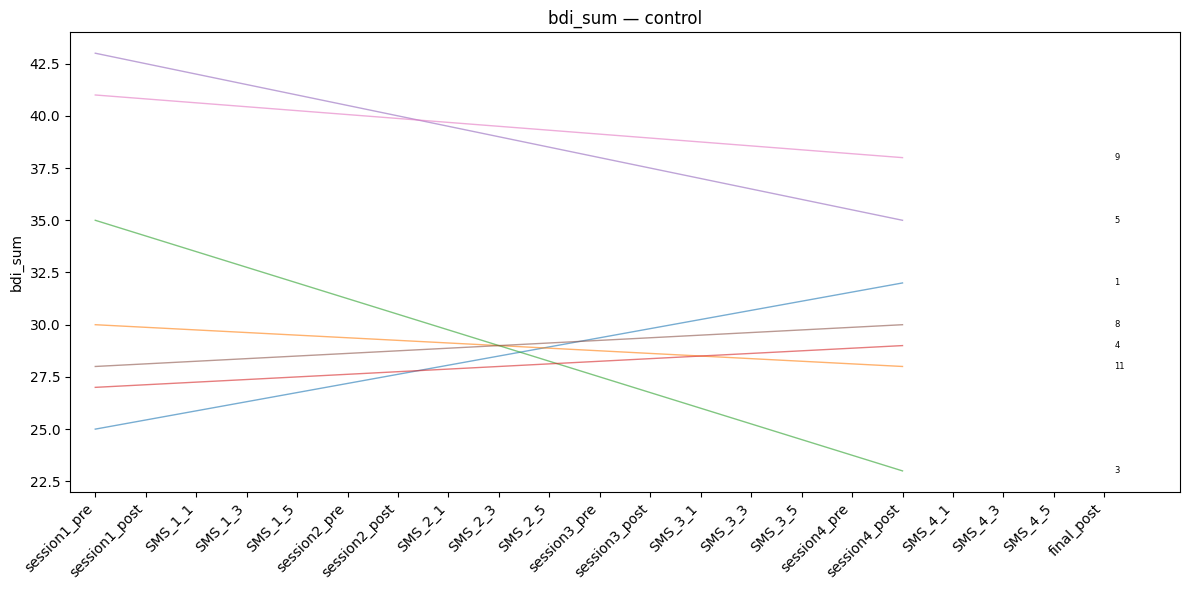

Worsened trajectories:


part_id      timepoint  bdi_sum
0       1   session1_pre     25.0
1       1  session4_post     32.0
2       4   session1_pre     27.0
3       4  session4_post     29.0
4       8   session1_pre     28.0
5       8  session4_post     30.0


── bdi_sum  |  Condition: intervention ──


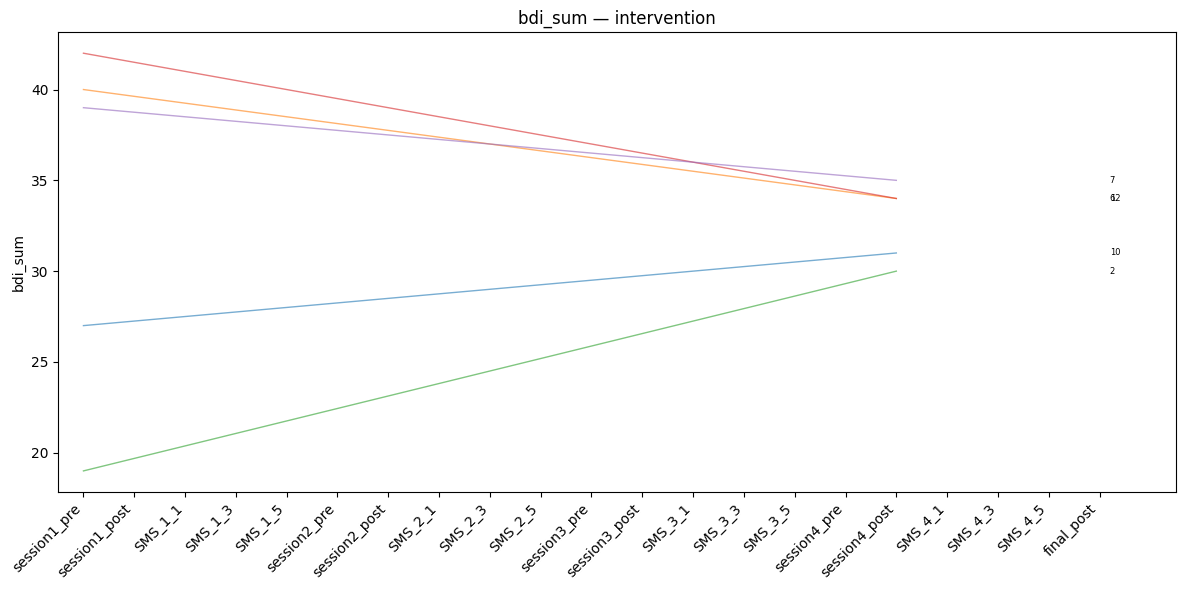

Worsened trajectories:


part_id      timepoint  bdi_sum
0      10   session1_pre     27.0
1      10  session4_post     31.0
2       2   session1_pre     19.0
3       2  session4_post     30.0


── bdi_sum  |  Condition: nan ──


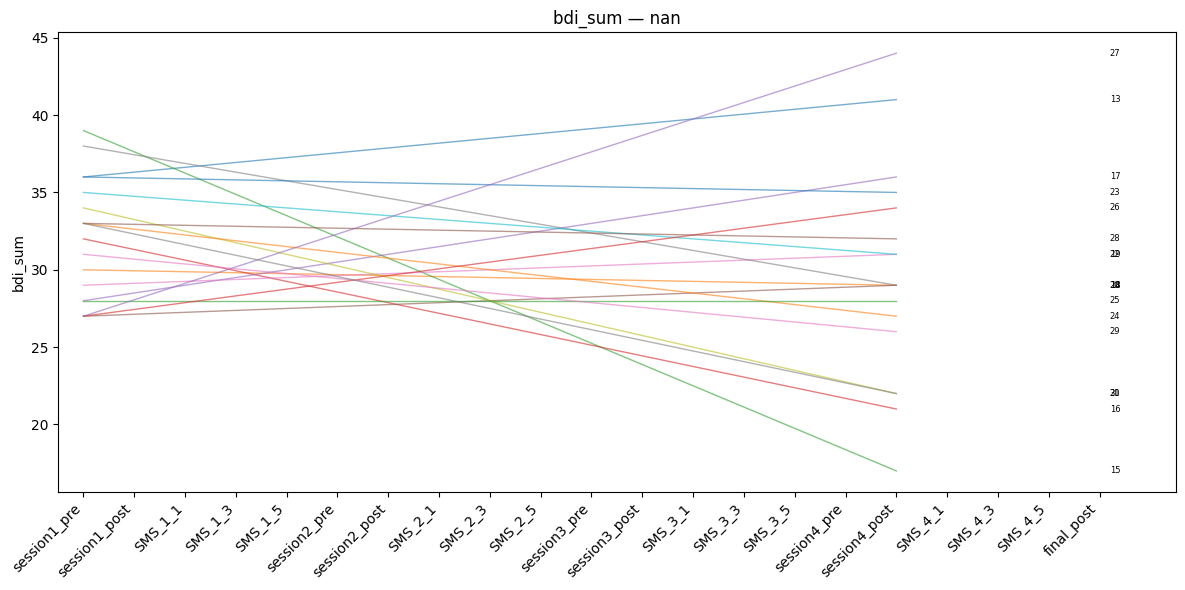

Worsened trajectories:


part_id      timepoint  bdi_sum
0       13   session1_pre     36.0
1       13  session4_post     41.0
2       17   session1_pre     28.0
3       17  session4_post     36.0
4       18   session1_pre     27.0
5       18  session4_post     29.0
6       19   session1_pre     29.0
7       19  session4_post     31.0
8       26   session1_pre     27.0
9       26  session4_post     34.0
10      27   session1_pre     27.0
11      27  session4_post     44.0


── MADRS_S_sum  |  Condition: control ──


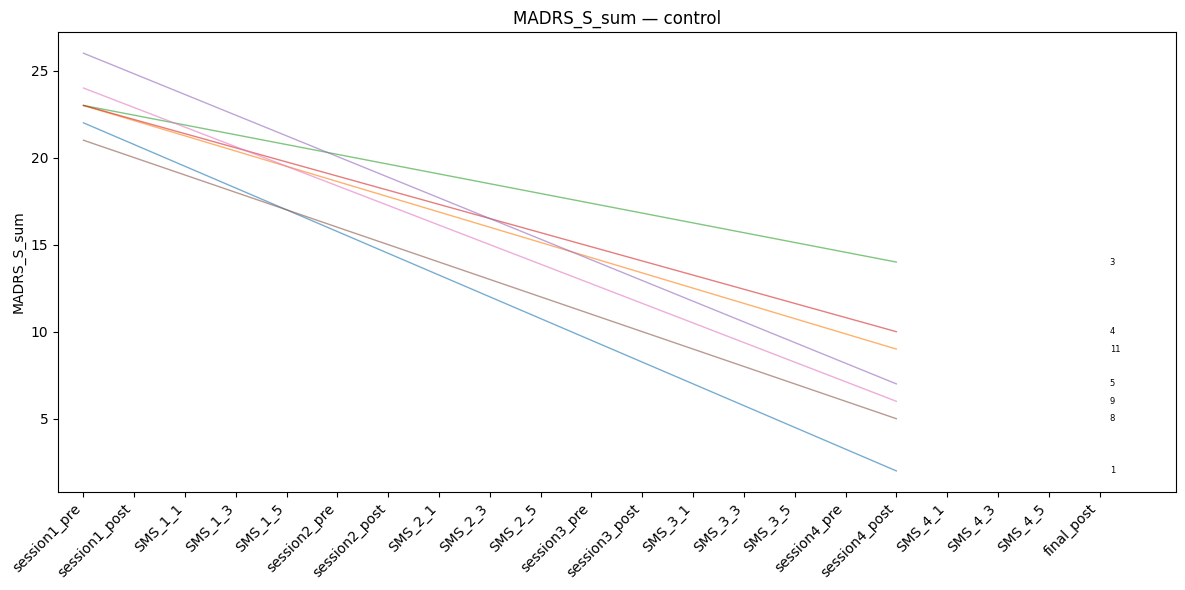

No worsening in this condition.

── MADRS_S_sum  |  Condition: intervention ──


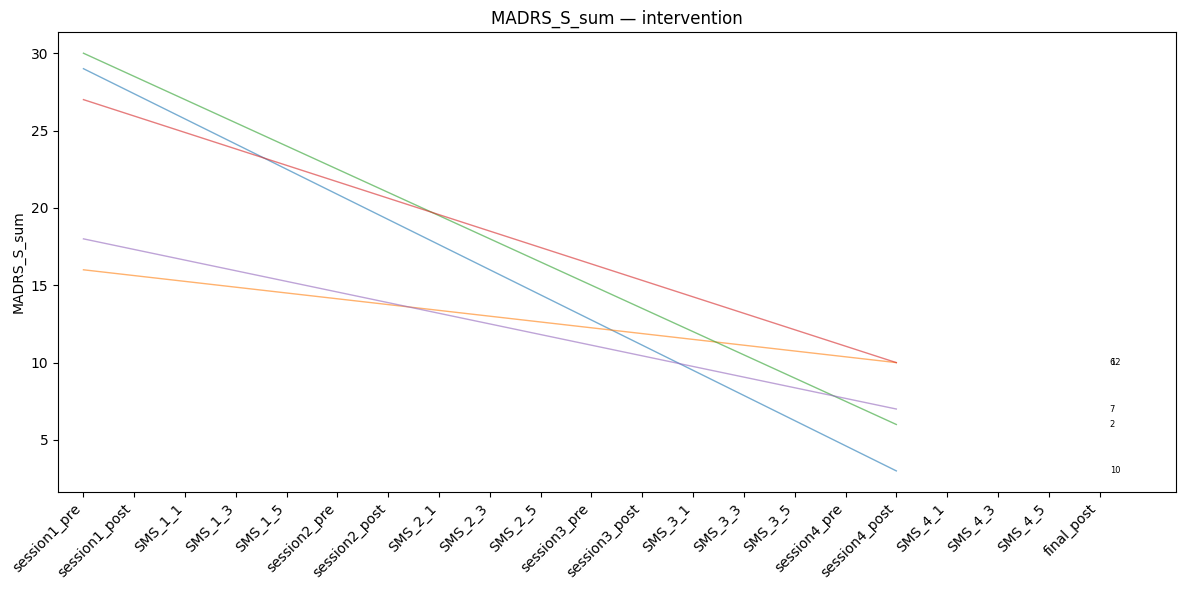

No worsening in this condition.

── MADRS_S_sum  |  Condition: nan ──


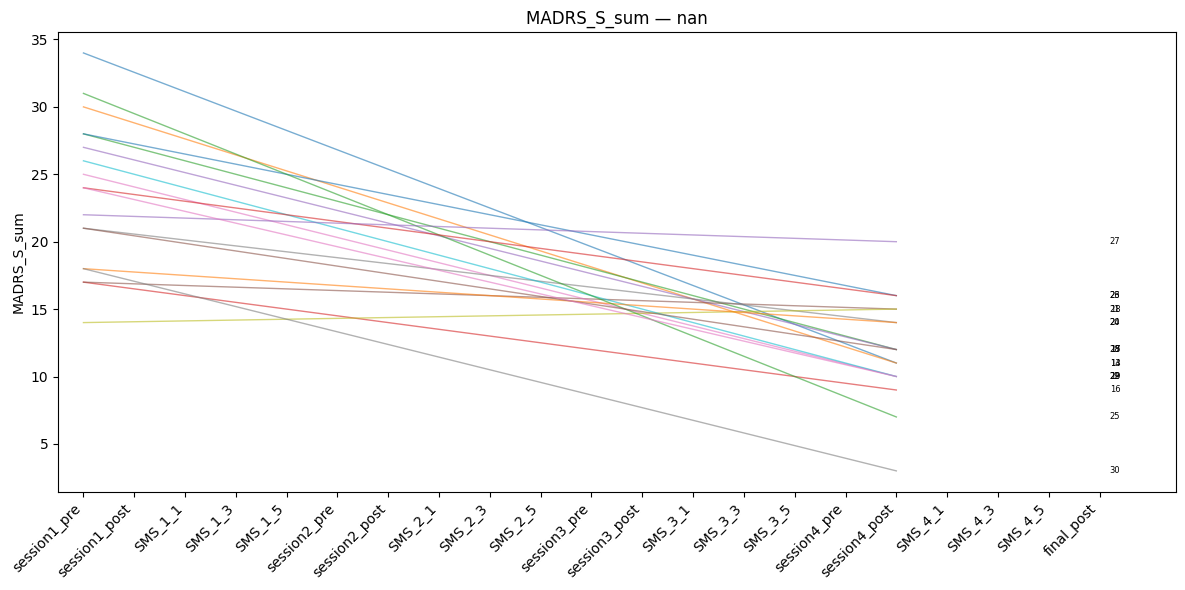

Worsened trajectories:


part_id      timepoint  MADRS_S_sum
0      21   session1_pre         14.0
1      21  session4_post         15.0

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.ticker import MaxNLocator

#####
# LOAD
#####
# Directory where your exports live
DATA_DIR = Path('/content')

def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching ‘{substring}’ in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match ‘{substring}’: {matches}")
    return matches[0]

def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching ‘{substring}’ in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match ‘{substring}’: {matches}")
    return matches[0]

df_s1_pre     = pd.read_csv(find_csv('pre_session_1'),     dtype=str)
df_s2to4_pre  = pd.read_csv(find_csv('pre_sessions_2-4'),  dtype=str)
df_s2to4_post = pd.read_csv(find_csv('post_sessions_1-3'), dtype=str)
df_s4_post    = pd.read_csv(find_csv('post_session_4'),    dtype=str)
df_sms        = pd.read_csv(find_csv('sms_day1,3,5'),      dtype=str)
df_final      = pd.read_csv(find_csv('sms_post'),          dtype=str)

all_dfs = [df_s1_pre, df_s2to4_pre, df_s2to4_post, df_s4_post, df_sms, df_final]

#####
# 1b) CLEAN BDI ITEMS (extract the leading number, not trailing)
#####
import re

for df in all_dfs:
    # find any bdi_# or bdi_#_1 column
    bdi_raw = [c for c in df.columns if re.fullmatch(r"bdi_\d+(?:_1)?", c)]
    for col in bdi_raw:
        # pull off the first group of digits, then cast to float
        df[col] = (
            df[col]
              .astype(str)
              .str.extract(r'^(\d+)')[0]
              .astype(float)
        )

#####
# helper to sum scales
#####
def sum_scale(df, cols, new_col):
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df[new_col] = df[cols].sum(axis=1)

def get_scale_cols(df, prefix, count, allow_suffix=False):
    cols = []
    for i in range(1, count+1):
        main = f"{prefix}_{i}"
        alt  = f"{prefix}_{i}_1"
        if main in df.columns:
            cols.append(main)
        elif allow_suffix and alt in df.columns:
            cols.append(alt)
    return cols

#####
# 2) COMPUTE SCALE TOTALS (where present)
#####
for df in all_dfs:
    # BAI
    bai_cols = get_scale_cols(df, 'bai', 21)
    if bai_cols:
        sum_scale(df, bai_cols, 'bai_sum')
    # BDI
    bdi_cols = get_scale_cols(df, 'bdi', 21)
    if bdi_cols:
        sum_scale(df, bdi_cols, 'bdi_sum')
    # MADRS (mards variants)
    mards_cols = get_scale_cols(df, 'mards', 9, allow_suffix=True)
    if mards_cols:
        sum_scale(df, mards_cols, 'MADRS_S_sum')

#####
# 3) STANDARDIZE M3VAS (–50:+50 → 0–100 & reverse‐code pleasure)
#####
def standardize_m3vas(df):
    for var in ('mood','pleasure','suicidal'):
        ch_cols  = [c for c in df.columns if re.fullmatch(f"m3vas_ch_{var}(?:_1)?", c)]
        raw_cols = [c for c in df.columns if re.fullmatch(f"m3vas_{var}(?:_1)?",    c)]
        if ch_cols:
            df[f"m3vas_{var}"] = pd.to_numeric(df[ch_cols[0]], errors='coerce') + 50
        elif raw_cols:
            df[f"m3vas_{var}"] = pd.to_numeric(df[raw_cols[0]], errors='coerce')
    if 'm3vas_pleasure' in df.columns:
        df['m3vas_pleasure'] = 100 - df['m3vas_pleasure']
    drop_pattern = re.compile(
        r"^(?:m3vas_ch_(?:mood|pleasure|suicidal)(?:_1)?|m3vas_(?:mood|pleasure|suicidal)_1)$"
    )
    to_drop = [c for c in df.columns if drop_pattern.match(c)]
    if to_drop:
        df.drop(columns=to_drop, inplace=True)

for df in all_dfs:
    standardize_m3vas(df)

#####
# 3b) CLEAN FISBER (extract trailing number)
#####
for df in all_dfs:
    for col in ('fisber_1','fisber_2','fisber_3'):
        if col in df.columns:
            df[col] = (
                df[col].astype(str)
                       .str.extract(r'(\d+)$')[0]
                       .astype(float)
            )

#####
# 4) COERCE TYPES
#####
# session_n for sessions
for df in (df_s1_pre, df_s2to4_pre, df_s2to4_post, df_s4_post):
    if 'session_n' in df.columns:
        df['session_n'] = pd.to_numeric(df['session_n'], errors='coerce').astype('Int64')

# session_n & sms_n for SMS
for col in ('session_n','sms_n'):
    if col in df_sms.columns:
        df_sms[col] = pd.to_numeric(df_sms[col], errors='coerce').astype('Int64')

# numeric scales
numeric_cols = [
    'phq9_sum','spane_p','spane_n',
    'm3vas_mood','m3vas_pleasure','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
]
for df in all_dfs:
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

#####
# ensure every DF has part_id
#####
for df in all_dfs:
    if 'part_id' not in df.columns:
        if 'ProlificID' in df.columns:
            df.rename(columns={'ProlificID':'part_id'}, inplace=True)
        else:
            df['part_id'] = df.index.astype(str)

#####
# 5) TAG TIMEPOINTS
#####
df_s1_pre    ['timepoint'] = 'session1_pre'
df_s2to4_pre ['timepoint'] = df_s2to4_pre .apply(lambda r: f"session{r.session_n}_pre",  axis=1)
df_s2to4_post['timepoint'] = df_s2to4_post.apply(lambda r: f"session{r.session_n}_post", axis=1)
df_s4_post   ['timepoint'] = 'session4_post'
df_sms       ['timepoint'] = df_sms      .apply(lambda r: f"SMS_{r.session_n}_{r.sms_n}", axis=1)
df_final     ['timepoint'] = 'final_post'

#####
# 6) CONCATENATE
#####
df_long = pd.concat(all_dfs, ignore_index=True)
df_long['part_id'] = df_long['part_id'].astype(str)

#####
# 6b) DROP the leftover Qualtrics-JSON artifact
#####
# Keep only rows where part_id is all digits
df_long = df_long[df_long['part_id'].str.match(r'^\d+$', na=False)]

#####
# 6c) MERGE IN CONDITION
#####
assign = pd.read_csv(find_csv('wp2_assignments'), dtype=str)
df_long = df_long.merge(assign[['part_id','condition']], on='part_id', how='left')

#####
# 7) DEFINE ORDERED TIMEPOINTS
#####
ordered_timepoints = [
    'session1_pre','session1_post',
    'SMS_1_1','SMS_1_3','SMS_1_5',
    'session2_pre','session2_post',
    'SMS_2_1','SMS_2_3','SMS_2_5',
    'session3_pre','session3_post',
    'SMS_3_1','SMS_3_3','SMS_3_5',
    'session4_pre','session4_post',
    'SMS_4_1','SMS_4_3','SMS_4_5',
    'final_post'
]

#####
# 8) PLOTTING + FLAGGING BY CONDITION
#####
bad_if_higher = {
    'phq9_sum','spane_n','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
}
bad_if_lower = {'spane_p','m3vas_mood','m3vas_pleasure'}

def plot_and_flag_by_condition(measure):
    if measure not in df_long.columns:
        print(f"→ skipping '{measure}': not in df_long")
        return

    for cond, dfc in df_long.groupby('condition', dropna=False):
        print(f"\n── {measure}  |  Condition: {cond} ──")
        fig, ax = plt.subplots(figsize=(12,6))
        x_final = len(ordered_timepoints) - 1

        # Plot each participant
        for pid, grp in dfc.groupby('part_id'):
            s = grp.dropna(subset=['timepoint', measure]).sort_values('timepoint')
            if s.empty: continue
            cat = pd.Categorical(s['timepoint'], categories=ordered_timepoints, ordered=True)
            x = cat.codes
            y = s[measure].astype(float)
            ax.plot(x, y, linewidth=1, alpha=0.6)
            ax.text(x_final + 0.2, y.iloc[-1], pid, fontsize=6, va='center')

        ax.set_xlim(-0.5, x_final + 1.5)
        ax.set_xticks(range(len(ordered_timepoints)))
        ax.set_xticklabels(ordered_timepoints, rotation=45, ha='right')
        ax.set_ylabel(measure)
        ax.set_title(f"{measure} — {cond}")
        plt.tight_layout()
        plt.show()

        # Flag worsened participants
        worsened = []
        for pid, grp in dfc.groupby('part_id'):
            seq = (grp
                   .dropna(subset=['timepoint', measure])
                   .sort_values('timepoint')[measure]
                   .astype(float))
            if len(seq) < 2:
                continue
            if ((measure in bad_if_higher and seq.iloc[-1] > seq.iloc[0]) or
                (measure in bad_if_lower and seq.iloc[-1] < seq.iloc[0])):
                worsened.append(pid)

        if worsened:
            df_flagged = (
                dfc[dfc['part_id'].isin(worsened)]
                  .loc[:, ['part_id','timepoint', measure]]
                  .dropna(subset=[measure])
                  .sort_values(['part_id','timepoint'])
                  .reset_index(drop=True)
            )
            print("Worsened trajectories:")
            display(df_flagged)
        else:
            print("No worsening in this condition.")

#####
# 9) RUN FOR ALL MEASURES
#####
measures = [
    'phq9_sum','spane_p','spane_n',
    'm3vas_mood','m3vas_pleasure','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
]
for m in measures:
    plot_and_flag_by_condition(m)

Mean Tolerability ± SD Assessment Across Sessions (Whole-Sample & Just-Adverse)
*   run previous monitoring and stratification scripts first to generate necessary dfs

In [ ]:
import numpy as np
import pandas as pd

#####
# 1) Compute tol_score (as before)
#####
tol_cols = [c for c in df_long.columns if c.lower().startswith('tol_follow')]
if tol_cols:
    for col in tol_cols:
        df_long[col] = (
            df_long[col]
              .astype(str)
              .str.extract(r'(\d+)', expand=False)
              .astype(float)
              .fillna(0)
        )
    df_long['tol_score'] = df_long[tol_cols].max(axis=1)
else:
    df_long['tol_score'] = np.nan

#####
# 2) Merge in condition from your assignments
#####
assign = pd.read_csv('wp2_assignments.csv', dtype=str)
df_long = df_long.merge(
    assign[['part_id','condition']],
    on='part_id',
    how='left'
)

#####
# 3) Restrict to post‐session timepoints
#####
post_tps = ['session1_post','session2_post','session3_post','session4_post']
tol_df = df_long[df_long['timepoint'].isin(post_tps)].copy()

#####
# 4a) Mean ± SD including zeros, by condition
#####
tol_stats_all = (
    tol_df
      .groupby(['condition','timepoint'], observed=False)['tol_score']
      .agg(['mean','std'])
      .rename(columns={'mean':'tol_mean_all','std':'tol_sd_all'})
      .round(2)
      .reset_index()
)

print("Tolerability score including zeros (mean ± SD), by condition:")
display(tol_stats_all.pivot(
    index='condition', columns='timepoint', values=['tol_mean_all','tol_sd_all']
))

#####
# 4b) Mean ± SD among only those with tol_score > 0, by condition
#####
tol_df_nz = tol_df[tol_df['tol_score'] > 0].copy()

tol_stats_nonzero = (
    tol_df_nz
      .groupby(['condition','timepoint'], observed=False)['tol_score']
      .agg(['mean','std','count'])
      .rename(columns={
         'mean':'tol_mean_nonzero',
         'std':'tol_sd_nonzero',
         'count':'n_side_effects'
      })
      .round(2)
      .reset_index()
)

print("Tolerability score among those with side effects (mean ± SD, N), by condition:")
display(tol_stats_nonzero.pivot(
    index='condition', columns='timepoint',
    values=['tol_mean_nonzero','tol_sd_nonzero','n_side_effects']
))

Tolerability score including zeros (mean ± SD), by condition:


tol_mean_all                                            \
timepoint    session1_post session2_post session3_post session4_post   
condition                                                              
control                3.0           2.0          4.50          2.29   
intervention           0.0           0.0          2.67          4.60   

                tol_sd_all                                            
timepoint    session1_post session2_post session3_post session4_post  
condition                                                             
control                5.2           4.0          6.36          3.90  
intervention           0.0           0.0          4.62          4.34

Tolerability score among those with side effects (mean ± SD, N), by condition:


tol_mean_nonzero                                            \
timepoint       session1_post session2_post session3_post session4_post   
condition                                                                 
control                   9.0           8.0           9.0          8.00   
intervention              NaN           NaN           8.0          7.67   

             tol_sd_nonzero                                            \
timepoint     session1_post session2_post session3_post session4_post   
condition                                                               
control                 NaN           NaN           NaN          0.00   
intervention            NaN           NaN           NaN          1.53   

             n_side_effects                                            
timepoint     session1_post session2_post session3_post session4_post  
condition                                                              
control                 1.0           1.0           1.0           2.0  
intervention            NaN           NaN           1.0           3.0